## TODO


    scrap for a data:
        - get x_rays images for healthy lungs and with illness
        - prepare labaled directories
        - ~split directiories into: train, val, test sets~
    *NEW* get the data:
        - since getting a nice and useful dataset from scrappin might be too much time consuming
        i will use already prepared kaggle's x_ray dataset
    plot the data:
        - confront healthy lungs with an ill one
    preprocess the data:
        - openCV:
            - what to do with this lib
            - how to preprocess images
            - can we save preprocessed images
            - does it have any data augmenations
            - for data augmentation i will oversample dataset
            - which preprocessing techniques are most viables and why, what does each of them is for
    build a model class:
        - init neural network model:
            - Since its image recognition task i will build CNN
            - build NN
        - perform training:
            1. get prediction
            2. compare it with actuall label
            3. optimize weights (not weights for labels)
            4. log results with proper /*metric*/:
                - which metric should i focus on and what are the main difference
                - As far as training dataset is conserned i will use accuracy since i will oversample that each class (Pneumonia/Normal) will have the same number of sample, but for validation i will use precision/recall to get info how many Positive labels are really true.
        - perform validatiion:
            steps are the same BUT we are not optimizing weights - we dont want to change weights durign validation process
        - callback:
            i want training to stop if it doesnt have any result after aprox ~ 5 epochs
        - logging:
            as mentioned I want to have everything logged:
                - trainingng process
                - validatiion process
                to see wheteher there is overfittin/underfitting
                And i want to have a clear comparison of metrics -> it will be used to determin quality of
                chosen models
    Perform training/validating
    Count how many predictions are ok and how many were wrong:
        - why they were wrong, plot images maybe to justify what they have incommon which influenced the results
    Mby here some statistics comparison for each models?
    
##  AFTER THIS:

    Testing?
    API:
        - i can create an API which will have prob one endpoint which accepts an Image of an x_ray to classify it
        as healthyy or not:
            * uploaded image will be preprocessed!
        - it should work asynchronously!
        - I want have celery workes so app will handle many executions
        - Database would be also nice to store uploaded image -> add it to the training data so it can become bigger
        - cover api with testing
        - cover api with handling such things like:
            - not a x_ray image
            - not a chest_x_ray image
            - bad quality of an image
    Contenerization:
        put everything into a docker
           

In [3]:
#WEB SCRAPPING

!pip install beautifulsoup4
!pip install requests

In [15]:
!pip install opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 16.5 MB/s eta 0:00:0000:0100:01


In [25]:
!pip install matplotlib

  Using cached matplotlib-3.6.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Using cached contourpy-1.0.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (296 kB)
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached Pillow-9.3.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.3 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached numpy-1.24.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)


In [57]:
!pip install Augmentor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 8.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=554c1c36d6478fa5714b39ca5f35ab8e3437a1d7f85524abf7ed6cf95a137e0a
  Stored in directory: /home/jakub/.cache/pip/wheels/dc/16/09/eb08b4e34e6b638f113d2018cf0b22de1d8dca22a3a71873f7
Successfully built future


In [3]:
import requests
import os
from urllib.request import urlretrieve
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import numpy as np
import Augmentor
from tqdm import tqdm

import torch
%matplotlib inline
sns.set_style('white')


In [2]:
#main address to look for images
healthy_chest_url = 'https://www.google.com/search?q=healthy+chest+x+ray+images&tbm=isch&ved=2ahUKEwi2w9u21ov8AhWrk4sKHfa2CqcQ2-cCegQIABAA&oq=healthy+chest+x+ray+images&gs_lcp=CgNpbWcQAzIECCMQJ1C0B1jOCGDKEGgAcAB4AIABSYgB0gGSAQEzmAEAoAEBqgELZ3dzLXdpei1pbWfAAQE&sclient=img&ei=T32jY_bfIKunrgT27aq4Cg&bih=973&biw=1920'
healthy_img_path = './x_ray_images/healthy/'

unhealthy_chest_url = 'https://www.google.com/search?q=unhealthy+chest+x+ray+images&tbm=isch&sxsrf=ALiCzsZI0FcI4kOCdd2popyoRs-A8j7d3w%3A1671658828311&source=hp&biw=1920&bih=973&ei=TH2jY6rrEPKtrgTZ7pr4Ag&iflsig=AJiK0e8AAAAAY6OLXB5j25XmJTsKkC7Kn2ligOJdTDL0&oq=&gs_lcp=CgNpbWcQARgAMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnUABYAGD3B2gBcAB4AIABAIgBAJIBAJgBAKoBC2d3cy13aXotaW1nsAEK&sclient=img'
unhealthy_img_path = './x_ray_images/unhealthy/'



In [5]:
#Create a function to webscrap google images to get x_rays of chest
def get_images(url: str, path: str):
    #get the url content
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    #get content with "img" and from these get source links
    get_all_tags = soup.find_all("img")
    links = [tag.get("src") for tag in get_all_tags]
    #create dir for images (healthy/unhealthy)
    if not os.path.exists(path):
        os.makedirs(path)
    #download images from given links
    for i, link in enumerate(links):
        try:
            urlretrieve(link, f'{path}/image no.{i}.jpg')
        except ValueError:
            continue  
    

In [22]:
#download healthy and unhealthy samples of x_ray_chest images
get_images(healthy_chest_url, healthy_img_path)
get_images(unhealthy_chest_url, unhealthy_img_path)

In [11]:
#plot those images to see whether samples could be good for training

def plot_images_from_dir(path: str):
    #get list of the directories content
    file_names = os.listdir(path)
    n_rows,n_cols = 4, 5
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))
    for ax, name in zip(axs.flat,file_names):
        img = mpimg.imread(os.path.join(path, name))
        ax.imshow(img)
        ax.set_title(name)
        ax.axis('off')
    plt.show()
    

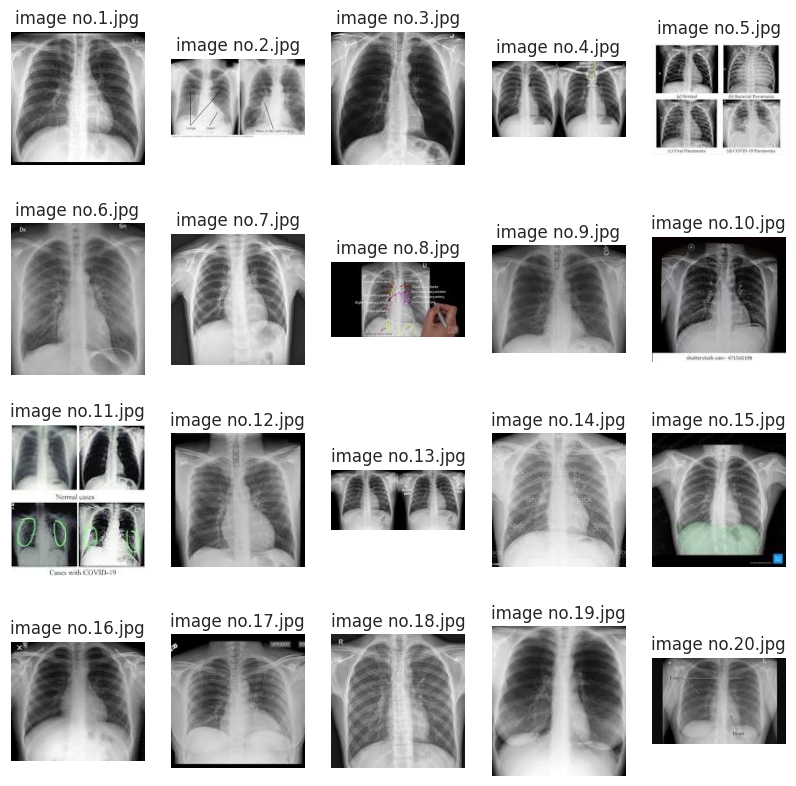

In [16]:
plot_images_from_dir(healthy_img_path)



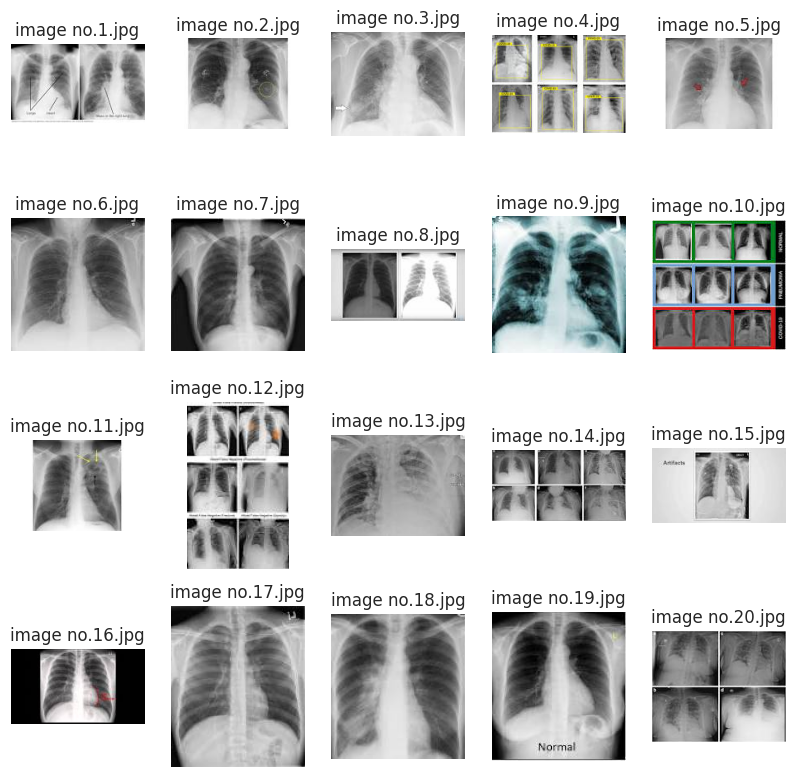

In [11]:
plot_images_from_dir(unhealthy_img_path)

It appears that many images are not good samples for training (there are unhealthy lungs in healthy directory). 
I suppose it will be hard to get nice dataset from scrapping so lets keep samples that looks good for further testing (from the API user point of view)but for the model training I will use one of Kaggle's datasets. Dataset is already splited into train, val and test directories which has 2 folders NORMAL and PNEUMONIA


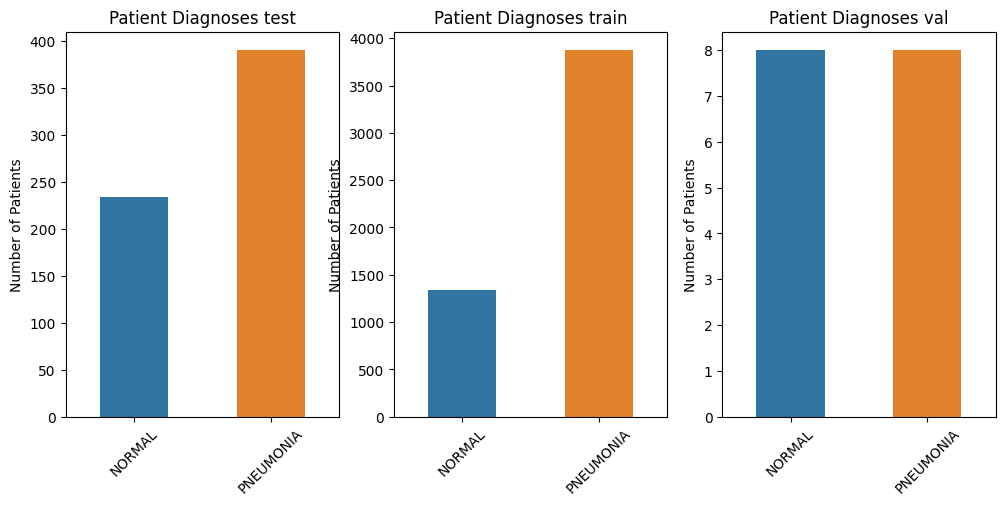

In [93]:
#investigate into dataset to show if there are any imbalances in the number of samples for each class
val = []      # list of quantity of samples for each class in each dataset
labels = ["NORMAL", "PNEUMONIA"]
for i in os.listdir('./chest_xray/'):
    tmp_val = []
    for label in labels:
        tmp = len(os.listdir(os.path.join(f'./chest_xray/{i}',label)))
        tmp_val.append(tmp)
    val.append(tmp_val)

fig, axs = plt.subplots(1,3, figsize=(12,5))
for ax, value, name in zip(axs, val, os.listdir('./chest_xray/')):
    colors = ['#1f77b4', '#ff7f0e']
    

    # Plot the bars
    sns.barplot(x=labels, y=value, palette=colors, ax=ax, width=0.5)

    # Add a title to the plot
    ax.set_title(f'Patient Diagnoses {name}')

    # Add a label to the y-axis
    ax.set_ylabel('Number of Patients')
    ax.set_xticklabels(labels, rotation=45)


    # Show the plot
plt.show()

As u can see classes of the datasets are imbalanced. In order to balance them i will oversample normal one. Additionaly in validation set there are only 16 images which is really low. My idea is to oversample training dataset, oversample validation set, combine them together and then split into 80-20/ 90-10 train/val set


In [4]:
train_normal_pic = './chest_xray/train/NORMAL/'
train_pneumonia_pic = './chest_xray/train/PNEUMONIA/'
test_normal_pic = './chest_xray/test/NORMAL/'
test_pneumonia_pic = './chest_xray/test/PNEUMONIA/'
val_normal_pic = './chest_xray/val/NORMAL/'
val_pneumonia_pic = './chest_xray/val/PNEUMONIA/'
all_dir = [train_normal_pic, train_pneumonia_pic, test_normal_pic, test_pneumonia_pic,
             val_normal_pic, val_pneumonia_pic]
for dirc in all_dir:
    print(dirc)
normal_pic = os.listdir(all_dir[0])
pneumonia_pic = os.listdir(all_dir[1])
print(normal_pic[0])

./chest_xray/train/NORMAL/
./chest_xray/train/PNEUMONIA/
./chest_xray/test/NORMAL/
./chest_xray/test/PNEUMONIA/
./chest_xray/val/NORMAL/
./chest_xray/val/PNEUMONIA/
IM-0115-0001.jpeg


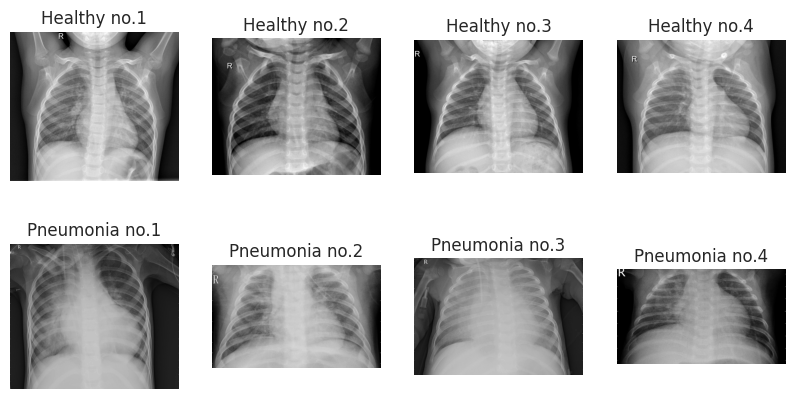

In [32]:
fig, ax = plt.subplots(2,4, figsize=(10,5))
for i, ax in zip(range(8), ax.flat):
    if i < 4:
        img = mpimg.imread(f'./chest_xray/train/NORMAL/{normal_pic[i]}')
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Healthy no.{i+1}')
        ax.axis('off')
    else:
        img = mpimg.imread(f'./chest_xray/train/PNEUMONIA//{pneumonia_pic[i]}')
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pneumonia no.{i-3}')
        ax.axis('off')
        
    
        
                   
    

Since some images of pneumonia are really rough to see by an eye I will experiment with some image preprocessing techniques in order to achieve better quality of the dataset

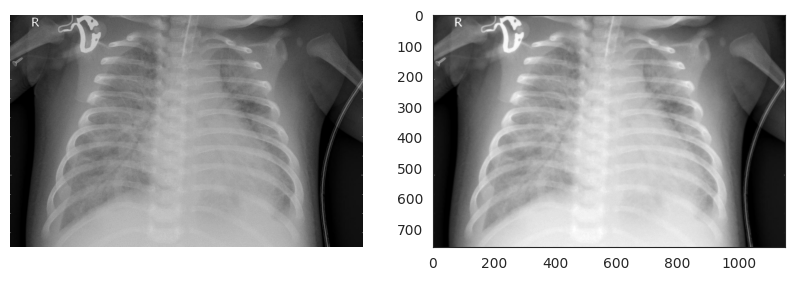

In [28]:
base_image = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[0]}', cv2.IMREAD_UNCHANGED)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(base_image, cmap='gray')
ax[0].axis('off')

#Gausian blur to compare it with original image to increase sharpness of the image
blure_img = cv2.GaussianBlur(base_image, (9, 9), 3.0)
image_sharp = cv2.addWeighted(base_image, 0.75, blure_img, 0.5, 0)
ax[1].imshow(image_sharp, cmap='gray')
plt.show()


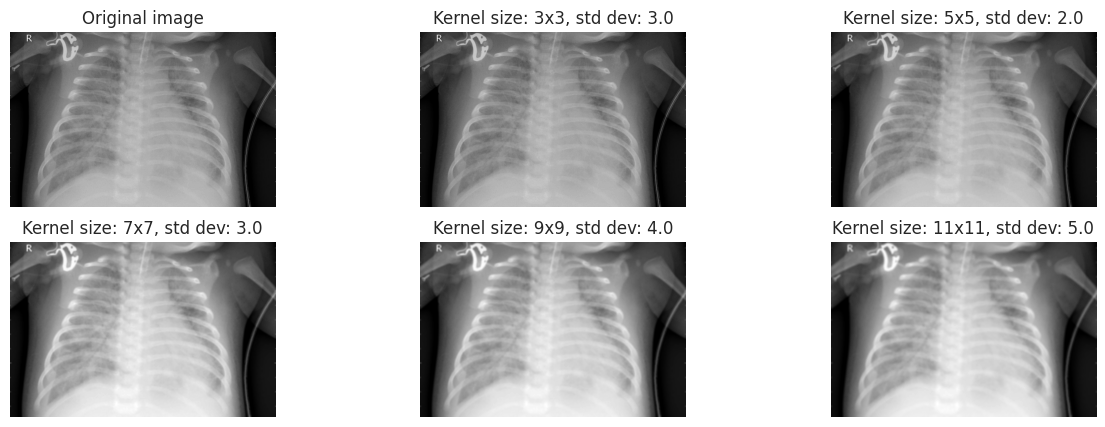

In [5]:
#Noise removal with gauss kernel
image = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[0]}', cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(2, 3, figsize=(15,5))
image_smoothed_1 = cv2.GaussianBlur(image, (1, 1), 1.0)
image_smoothed_2 = cv2.GaussianBlur(image, (5, 5), 2.0)
image_smoothed_3 = cv2.GaussianBlur(image, (7, 7), 7.0)
image_smoothed_4 = cv2.GaussianBlur(image, (9, 9), 4.0)
image_smoothed_5 = cv2.GaussianBlur(image, (11,11), 5.0)
images = [image, image_smoothed_1, image_smoothed_2, image_smoothed_3,
         image_smoothed_4,image_smoothed_5]
titles = ['Original image','Kernel size: 3x3, std dev: 3.0','Kernel size: 5x5, std dev: 2.0',
          'Kernel size: 7x7, std dev: 3.0','Kernel size: 9x9, std dev: 4.0','Kernel size: 11x11, std dev: 5.0']
for axs, title, img in zip(ax.flat, titles, images):
    axs.imshow(img, cmap='gray')
    axs.set_title(title)
    axs.axis('off')

plt.show()

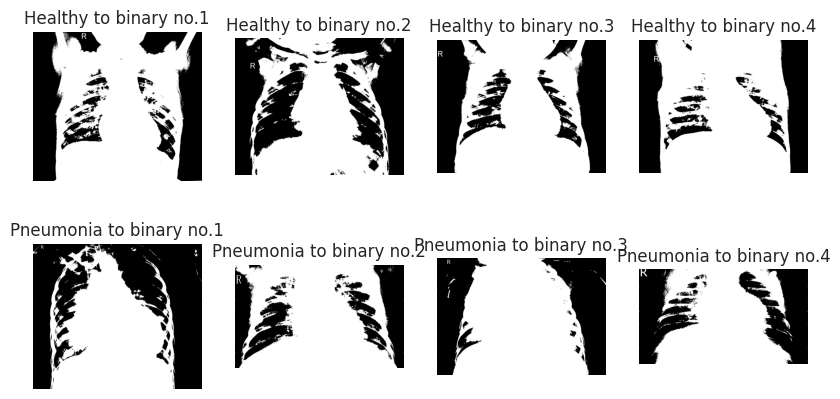

In [27]:
#Transform images into binary ones
fig, ax = plt.subplots(2,4, figsize=(10,5))
for i, ax in zip(range(8), ax.flat):
    if i < 4:
        img = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[i]}', cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(img, 50, 100, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Healthy to binary no.{i+1}')
        ax.axis('off')
    else:
        img = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[i]}', cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(img, 50, 100, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pneumonia to binary no.{i-3}')
        ax.axis('off')

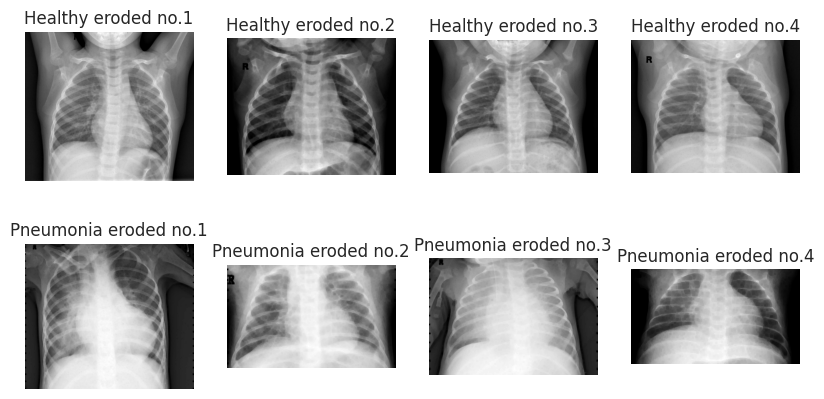

In [4]:
#erosion
fig, ax = plt.subplots(2,4, figsize=(10,5))
kernel = np.ones((11,11), np.uint8)
for i, ax in zip(range(8), ax.flat):
    if i < 4:
        img = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[i]}', cv2.IMREAD_GRAYSCALE)
        img = cv2.erode(img, kernel,iterations=1)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Healthy eroded no.{i+1}')
        ax.axis('off')
    else:
        img = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[i]}', cv2.IMREAD_GRAYSCALE)
        img = cv2.erode(img, kernel,iterations=1)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pneumonia eroded no.{i-3}')
        ax.axis('off')

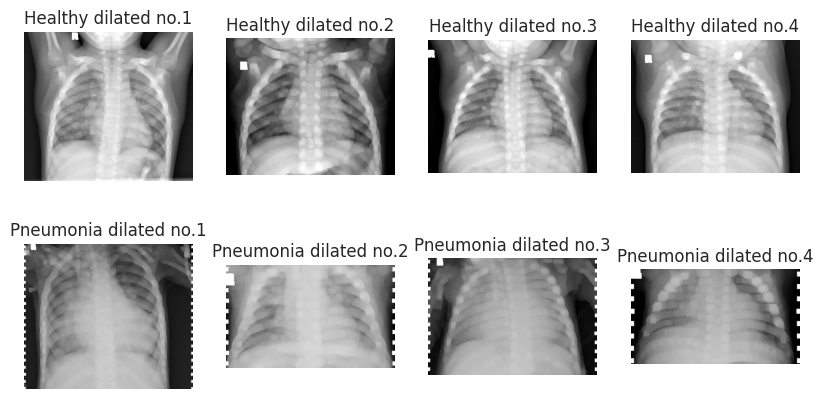

In [6]:
#dilation
fig, ax = plt.subplots(2,4, figsize=(10,5))
kernel = np.ones((9,9), np.uint8)
for i, ax in zip(range(8), ax.flat):
    if i < 4:
        img = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[i]}', cv2.IMREAD_GRAYSCALE)
        img = cv2.dilate(img, kernel,iterations=3)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Healthy dilated no.{i+1}')
        ax.axis('off')
    else:
        img = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[i]}', cv2.IMREAD_GRAYSCALE)
        img = cv2.dilate(img, kernel,iterations=3)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pneumonia dilated no.{i-3}')
        ax.axis('off')

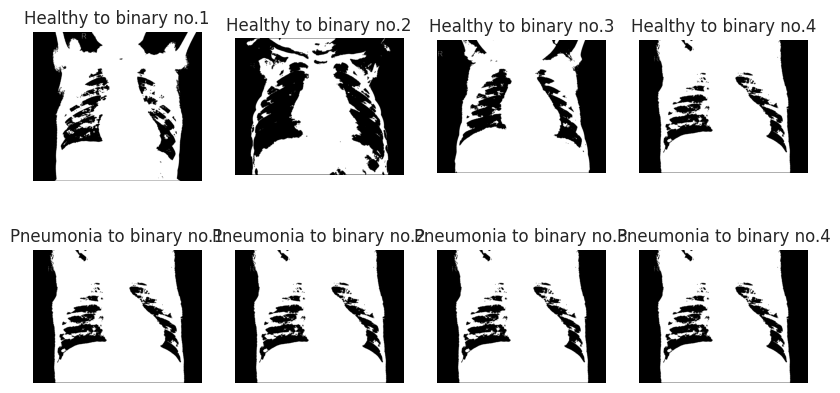

In [8]:
#try to draw contours on binary images
fig, ax = plt.subplots(2,4, figsize=(10,5))
for i, ax in zip(range(8), ax.flat):
    if i < 4:
        image = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[i]}', cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, (0,255,0), 3)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Healthy to binary no.{i+1}')
        ax.axis('off')
    else:
        img = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[i]}', cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, (0,255,0), 3)
        ax.imshow(img, cmap='gray')
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pneumonia to binary no.{i-3}')
        ax.axis('off')

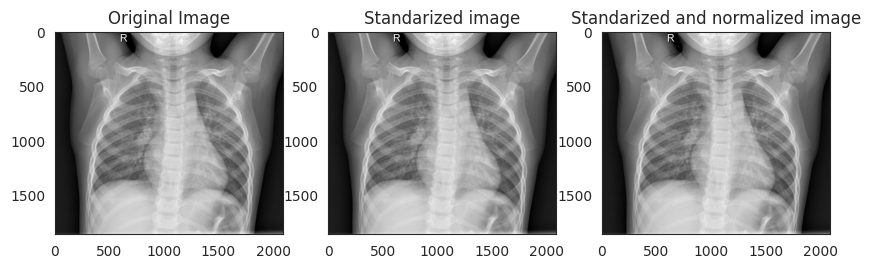

In [32]:
#Normalization n standarization 
fig, ax = plt.subplots(1,3, figsize=(10,5))
img = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[0]}')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
standardized = (gray_img - np.mean(gray_img)) / np.std(gray_img)
normalized = (standardized - np.min(standardized)) / (np.max(standardized) - np.min(standardized))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(standardized, cmap='gray')
ax[1].set_title('Standarized image')
ax[2].imshow(normalized, cmap='gray')
ax[2].set_title('Standarized and normalized image')
plt.show()
    

In [47]:
def preprocess_image(img_path: str):
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    erosion_kernel = np.ones((9,9), np.uint8)
#     standardized = (gray_img - np.mean(gray_img)) / np.std(gray_img)
#     normalized = (standardized - np.min(standardized)) / (np.max(standardized) - np.min(standardized))
    blure_img = cv2.GaussianBlur(gray_img, (3, 3), 3.0)
    image_sharp = cv2.addWeighted(gray_img, 0.75, blure_img, 0.75, 0)
    eroded = cv2.erode(image_sharp, erosion_kernel,iterations=1)
#     img_resized = cv2.resize(eroded, (640,420))
    return eroded

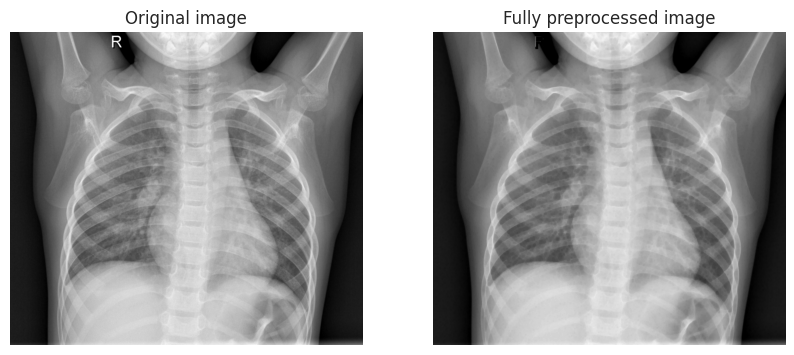

In [10]:
# Compare original image with an image fully preprocessed (normalization, stadarization, erosion, increased_sharpness)
img = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[0]}')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
erosion_kernel = np.ones((9,9), np.uint8)
standardized = (gray_img - np.mean(gray_img)) / np.std(gray_img)
normalized = (standardized - np.min(standardized)) / (np.max(standardized) - np.min(standardized))
blure_img = cv2.GaussianBlur(normalized, (3, 3), 3.0)
image_sharp = cv2.addWeighted(normalized, 0.75, blure_img, 0.5, 0)
eroded = cv2.erode(image_sharp, erosion_kernel,iterations=1)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(eroded, cmap='gray')
ax[1].set_title('Fully preprocessed image')
ax[1].axis('off')
plt.show()




In [6]:
#New directories for preprocessed images
paths = ['./chest_xray_prep/train/NORMAL/','./chest_xray_prep/train/PNEUMONIA/',
         './chest_xray_prep/test/NORMAL/','./chest_xray_prep/test/PNEUMONIA/',
         './chest_xray_prep/val/NORMAL/', './chest_xray_prep/val/NORMAL/']
norm_paths = ['./chest_xray/train/NORMAL/','./chest_xray/train/PNEUMONIA/']
val_paths = ['./chest_xray/val/NORMAL/','./chest_xray/val/PNEUMONIA/']
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

To correctly save images I would have to extend the value of pixels which will colide with normalization and standardization techniques. To break this issue I will not normalize/standardize image during 1st preprocess step. I will do it while loading input to the models. To sum up data pipeline will look like this:
    1. Preproces image applying gausian blur (which helps up with the img sharpness) and erosion
    2. Augment image to perform oversampling to make each class equal with the quantity of samples
    3. Split images into batches
    4. Resize, standardize and normalize each image while puting it into a model

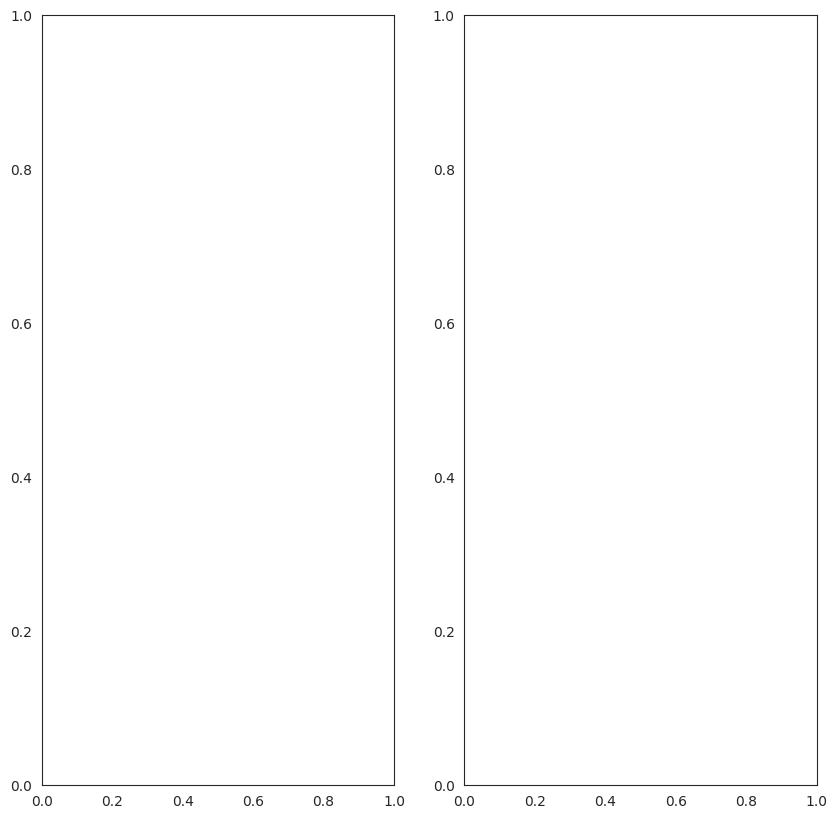

In [49]:
#Save preprocessed images to the new directories
fig, ax = plt.subplots(1, 2, figsize=(10,10))
for directory, path in zip(all_dir, paths):
    for i, picture in enumerate(os.listdir(directory)):
        prep = preprocess_image(os.path.join(directory, picture))
#         ax[0].imshow(prep, cmap='gray')
#         print(prep.dtype)
        cv2.imwrite(f'{path}{i}.png', prep)
#         example = cv2.imread(f'{path}{i}.png')
#         print(example.dtype)
#         ax[1].imshow(example)
        
#         break
        
    
    
    
    

Unfortunatelly there are many samples which are not readable after this preprocessing, so not to overload the model. Lets focus now on data augmentation to oversample classes and while loading data in DataLoader images will be resized, normalized and standardized. If the results will be not sattisfing. More img preprocessing techniques will be applied

In [8]:
for path in paths[:2]:
    print(path, len(os.listdir(path)))

./chest_xray_prep/train/NORMAL/ 1342
./chest_xray_prep/train/PNEUMONIA/ 3876


In [12]:
#Oversample training data with augmentation
for path in tqdm(norm_paths):    
    p = Augmentor.Pipeline(f'{path}')
    p.rotate(probability=0.8, max_left_rotation=15, max_right_rotation=15)
    p.flip_left_right(probability=0.8)
    p.random_distortion(probability=0.8, grid_width=12, grid_height=12, magnitude=4)
    p.shear(probability=0.8, max_shear_left=15, max_shear_right=15)
    p.sample(4500, multi_threaded=True)
    

  0%|                                                                                                                                            | 0/2 [00:00<?, ?it/s]

Initialised with 1341 image(s) found.
Output directory set to ./chest_xray/train/NORMAL/output.


Executing Pipeline:   0%|                                                                                                               | 0/4500 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=L size=1284x1020 at 0x7F3B3012DFC0>:   0%|                                                       | 0/4500 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=L size=1284x1020 at 0x7F3B3012DFC0>:   0%|                                               | 1/4500 [00:00<46:31,  1.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=2098x1770 at 0x7F3B582D4070>:   0%|                                               | 1/4500 [00:01<46:31,  1.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=2098x1770 at 0x7F3B582D4070>:   0%|                                             | 2/4500 [00:01<1:11:36,  1.05 Samples/s]
Processing <PIL.Image.Image image mode=L size=1620x1527 at 0x7F3B582D40D0>:   0%|                                             | 2/4500 [00:01<1:11:36,  1.05 Sa

Processing <PIL.Image.Image image mode=L size=1496x1333 at 0x7F3B58176770>:   2%|▊                                             | 74/4500 [00:05<05:22, 13.72 Samples/s]
Processing <PIL.Image.Image image mode=L size=1496x1333 at 0x7F3B58176770>:   2%|▊                                             | 75/4500 [00:05<04:04, 18.09 Samples/s]
Processing <PIL.Image.Image image mode=L size=2056x2206 at 0x7F3B58177D60>:   2%|▊                                             | 75/4500 [00:05<04:04, 18.09 Samples/s]
Processing <PIL.Image.Image image mode=L size=2346x2032 at 0x7F3B58175840>:   2%|▊                                             | 76/4500 [00:06<04:04, 18.09 Samples/s]
Processing <PIL.Image.Image image mode=L size=1354x1024 at 0x7F3B58174EB0>:   2%|▊                                             | 77/4500 [00:06<04:04, 18.09 Samples/s]
Processing <PIL.Image.Image image mode=L size=1246x951 at 0x7F3B0D8F2080>:   2%|▊                                              | 78/4500 [00:06<04:04, 18.09 Sam

Processing <PIL.Image.Image image mode=L size=1336x1128 at 0x7F3B5824EB00>:   3%|█▌                                           | 151/4500 [00:11<06:11, 11.71 Samples/s]
Processing <PIL.Image.Image image mode=L size=1638x1279 at 0x7F3B5824C880>:   3%|█▌                                           | 152/4500 [00:11<06:11, 11.71 Samples/s]
Processing <PIL.Image.Image image mode=L size=1630x1353 at 0x7F3B5824FA60>:   3%|█▌                                           | 153/4500 [00:11<06:11, 11.71 Samples/s]
Processing <PIL.Image.Image image mode=L size=1584x1237 at 0x7F3B3012C3A0>:   3%|█▌                                           | 154/4500 [00:11<06:11, 11.71 Samples/s]
Processing <PIL.Image.Image image mode=L size=1584x1237 at 0x7F3B3012C3A0>:   3%|█▌                                           | 155/4500 [00:11<04:32, 15.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1500x1294 at 0x7F3B5824D450>:   3%|█▌                                           | 155/4500 [00:11<04:32, 15.93 Sam

Processing <PIL.Image.Image image mode=L size=1310x1071 at 0x7F3B59B0E4A0>:   5%|██▎                                          | 230/4500 [00:15<04:05, 17.38 Samples/s]
Processing <PIL.Image.Image image mode=L size=1932x1561 at 0x7F3B5821C970>:   5%|██▎                                          | 230/4500 [00:15<04:05, 17.38 Samples/s]
Processing <PIL.Image.Image image mode=L size=1268x885 at 0x7F3B5821CB80>:   5%|██▎                                           | 231/4500 [00:15<04:05, 17.38 Samples/s]
Processing <PIL.Image.Image image mode=L size=1518x1156 at 0x7F3B5821D5D0>:   5%|██▎                                          | 232/4500 [00:15<04:05, 17.38 Samples/s]
Processing <PIL.Image.Image image mode=L size=1936x1612 at 0x7F3B5821F9D0>:   5%|██▎                                          | 233/4500 [00:15<04:05, 17.38 Samples/s]
Processing <PIL.Image.Image image mode=L size=1462x1171 at 0x7F3B5821F8E0>:   5%|██▎                                          | 234/4500 [00:15<04:05, 17.38 Sam

Processing <PIL.Image.Image image mode=L size=1846x1488 at 0x7F3B0DBAECB0>:   7%|███                                          | 307/4500 [00:19<04:03, 17.25 Samples/s]
Processing <PIL.Image.Image image mode=L size=1616x1318 at 0x7F3B0DBAFAF0>:   7%|███                                          | 308/4500 [00:19<04:02, 17.25 Samples/s]
Processing <PIL.Image.Image image mode=L size=1442x1229 at 0x7F3B0DBAC580>:   7%|███                                          | 309/4500 [00:19<04:02, 17.25 Samples/s]
Processing <PIL.Image.Image image mode=L size=1538x986 at 0x7F3B0DBAFAC0>:   7%|███▏                                          | 310/4500 [00:19<04:02, 17.25 Samples/s]
Processing <PIL.Image.Image image mode=L size=1538x986 at 0x7F3B0DBAFAC0>:   7%|███▏                                          | 311/4500 [00:19<03:08, 22.19 Samples/s]
Processing <PIL.Image.Image image mode=L size=1040x747 at 0x7F3B0DBAF790>:   7%|███▏                                          | 311/4500 [00:19<03:08, 22.19 Sam

Processing <PIL.Image.Image image mode=L size=1546x1255 at 0x7F3B0D806BC0>:   9%|███▊                                         | 387/4500 [00:25<06:38, 10.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1546x1271 at 0x7F3B0D8AA650>:   9%|███▊                                         | 387/4500 [00:25<06:38, 10.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1442x1214 at 0x7F3B0D8F2D40>:   9%|███▉                                         | 388/4500 [00:25<06:38, 10.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1516x1295 at 0x7F3B0D806350>:   9%|███▉                                         | 389/4500 [00:25<06:38, 10.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=2014x1577 at 0x7F3B0D8A8F40>:   9%|███▉                                         | 390/4500 [00:25<06:37, 10.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1658x1183 at 0x7F3B0D8AA830>:   9%|███▉                                         | 391/4500 [00:25<06:37, 10.33 Sam

Processing <PIL.Image.Image image mode=L size=1748x1299 at 0x7F3B0D8F3FD0>:  10%|████▋                                        | 465/4500 [00:29<02:32, 26.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=1882x1855 at 0x7F3B5A17B550>:  10%|████▋                                        | 465/4500 [00:29<02:32, 26.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=1538x1222 at 0x7F3B5A17A770>:  10%|████▋                                        | 466/4500 [00:29<02:32, 26.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=1620x1340 at 0x7F3B5A178FA0>:  10%|████▋                                        | 467/4500 [00:29<02:32, 26.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=1546x1425 at 0x7F3B0D807F70>:  10%|████▋                                        | 468/4500 [00:29<02:32, 26.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=1546x1425 at 0x7F3B0D807F70>:  10%|████▋                                        | 469/4500 [00:29<02:47, 24.05 Sam

Processing <PIL.Image.Image image mode=L size=1646x1476 at 0x7F3B58159E70>:  12%|█████▍                                       | 543/4500 [00:34<03:37, 18.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=2014x1577 at 0x7F3B0D8F0B80>:  12%|█████▍                                       | 543/4500 [00:34<03:37, 18.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=1990x1666 at 0x7F3B0D8F0F40>:  12%|█████▍                                       | 544/4500 [00:34<03:37, 18.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=1346x1044 at 0x7F3B5815B370>:  12%|█████▍                                       | 545/4500 [00:34<03:37, 18.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=1350x1090 at 0x7F3B0D8F2920>:  12%|█████▍                                       | 546/4500 [00:34<03:37, 18.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=1402x1117 at 0x7F3B0D8F2CE0>:  12%|█████▍                                       | 547/4500 [00:34<03:37, 18.18 Sam

Processing <PIL.Image.Image image mode=L size=1738x1430 at 0x7F3B0D807E80>:  14%|██████▏                                      | 622/4500 [00:39<02:18, 28.01 Samples/s]
Processing <PIL.Image.Image image mode=L size=1766x1557 at 0x7F3B0D8F17E0>:  14%|██████▏                                      | 623/4500 [00:39<02:18, 28.01 Samples/s]
Processing <PIL.Image.Image image mode=L size=1878x1654 at 0x7F3B59BD9840>:  14%|██████▏                                      | 624/4500 [00:39<02:18, 28.01 Samples/s]
Processing <PIL.Image.Image image mode=L size=1878x1654 at 0x7F3B59BD9840>:  14%|██████▎                                      | 625/4500 [00:39<02:23, 26.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1948x1576 at 0x7F3B0D8F1810>:  14%|██████▎                                      | 625/4500 [00:39<02:23, 26.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1712x1430 at 0x7F3B0D8F27D0>:  14%|██████▎                                      | 626/4500 [00:39<02:23, 26.93 Sam

Processing <PIL.Image.Image image mode=L size=1608x1468 at 0x7F3B0D8F0F70>:  16%|██████▉                                      | 698/4500 [00:44<03:46, 16.77 Samples/s]
Processing <PIL.Image.Image image mode=L size=1480x1228 at 0x7F3B0D8F1990>:  16%|██████▉                                      | 698/4500 [00:44<03:46, 16.77 Samples/s]
Processing <PIL.Image.Image image mode=L size=1460x1233 at 0x7F3B0D8F2E30>:  16%|██████▉                                      | 699/4500 [00:44<03:46, 16.77 Samples/s]
Processing <PIL.Image.Image image mode=L size=1736x1785 at 0x7F3B5815AB30>:  16%|███████                                      | 700/4500 [00:44<03:46, 16.77 Samples/s]
Processing <PIL.Image.Image image mode=L size=1882x1692 at 0x7F3B0D8F0F10>:  16%|███████                                      | 701/4500 [00:44<03:46, 16.77 Samples/s]
Processing <PIL.Image.Image image mode=L size=1894x1688 at 0x7F3B59CA38E0>:  16%|███████                                      | 702/4500 [00:44<03:46, 16.77 Sam

Processing <PIL.Image.Image image mode=L size=1662x1214 at 0x7F3B59C42560>:  17%|███████▋                                     | 774/4500 [00:49<04:39, 13.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=2138x1928 at 0x7F3B59CD4D00>:  17%|███████▊                                     | 775/4500 [00:49<04:39, 13.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=2222x1669 at 0x7F3B59CD4D30>:  17%|███████▊                                     | 776/4500 [00:49<04:39, 13.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1882x1480 at 0x7F3B59C43430>:  17%|███████▊                                     | 777/4500 [00:49<04:39, 13.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1882x1480 at 0x7F3B59C43430>:  17%|███████▊                                     | 778/4500 [00:49<03:43, 16.64 Samples/s]
Processing <PIL.Image.Image image mode=L size=1766x1611 at 0x7F3B59CD7D60>:  17%|███████▊                                     | 778/4500 [00:49<03:43, 16.64 Sam

Processing <PIL.Image.Image image mode=L size=1528x1013 at 0x7F3B0D807340>:  19%|████████▌                                    | 851/4500 [00:55<07:23,  8.23 Samples/s]
Processing <PIL.Image.Image image mode=L size=1306x1047 at 0x7F3B0D805180>:  19%|████████▌                                    | 852/4500 [00:55<07:23,  8.23 Samples/s]
Processing <PIL.Image.Image image mode=L size=1306x1047 at 0x7F3B0D805180>:  19%|████████▌                                    | 853/4500 [00:55<05:16, 11.52 Samples/s]
Processing <PIL.Image.Image image mode=L size=1782x1433 at 0x7F3B59CD4C70>:  19%|████████▌                                    | 853/4500 [00:55<05:16, 11.52 Samples/s]
Processing <PIL.Image.Image image mode=L size=2138x1928 at 0x7F3B59CD6AD0>:  19%|████████▌                                    | 854/4500 [00:55<05:16, 11.52 Samples/s]
Processing <PIL.Image.Image image mode=L size=1442x1148 at 0x7F3B59CD6D10>:  19%|████████▌                                    | 855/4500 [00:55<05:16, 11.52 Sam

Processing <PIL.Image.Image image mode=L size=1300x1051 at 0x7F3B59B8FF40>:  21%|█████████▎                                   | 928/4500 [00:59<04:00, 14.85 Samples/s]
Processing <PIL.Image.Image image mode=L size=976x800 at 0x7F3B59B8D240>:  21%|█████████▋                                     | 929/4500 [00:59<04:00, 14.85 Samples/s]
Processing <PIL.Image.Image image mode=L size=1330x1132 at 0x7F3B59B8E860>:  21%|█████████▎                                   | 930/4500 [00:59<04:00, 14.85 Samples/s]
Processing <PIL.Image.Image image mode=L size=1330x1132 at 0x7F3B59B8E860>:  21%|█████████▎                                   | 931/4500 [00:59<02:55, 20.37 Samples/s]
Processing <PIL.Image.Image image mode=L size=1882x1480 at 0x7F3B59B8FF70>:  21%|█████████▎                                   | 931/4500 [00:59<02:55, 20.37 Samples/s]
Processing <PIL.Image.Image image mode=L size=1372x1109 at 0x7F3B59B8D180>:  21%|█████████▎                                   | 932/4500 [00:59<02:55, 20.37 Sam

Processing <PIL.Image.Image image mode=L size=2358x1959 at 0x7F3B59BA3940>:  22%|█████████▊                                  | 1008/4500 [01:04<02:56, 19.83 Samples/s]
Processing <PIL.Image.Image image mode=L size=1218x1032 at 0x7F3B59BA14E0>:  22%|█████████▊                                  | 1009/4500 [01:04<02:56, 19.83 Samples/s]
Processing <PIL.Image.Image image mode=L size=1218x1032 at 0x7F3B59BA14E0>:  22%|█████████▉                                  | 1010/4500 [01:04<03:51, 15.10 Samples/s]
Processing <PIL.Image.Image image mode=L size=1696x1298 at 0x7F3B59BA1B40>:  22%|█████████▉                                  | 1010/4500 [01:04<03:51, 15.10 Samples/s]
Processing <PIL.Image.Image image mode=L size=1118x932 at 0x7F3B59BA0430>:  22%|██████████                                   | 1011/4500 [01:04<03:51, 15.10 Samples/s]
Processing <PIL.Image.Image image mode=L size=1252x1028 at 0x7F3B59BA1060>:  22%|█████████▉                                  | 1012/4500 [01:04<03:51, 15.10 Sam

Processing <PIL.Image.Image image mode=L size=1644x1487 at 0x7F3B5A1FDA50>:  24%|██████████▌                                 | 1085/4500 [01:08<02:43, 20.82 Samples/s]
Processing <PIL.Image.Image image mode=L size=1644x1487 at 0x7F3B5A1FDA50>:  24%|██████████▌                                 | 1086/4500 [01:08<02:28, 23.03 Samples/s]
Processing <PIL.Image.Image image mode=L size=1238x874 at 0x7F3C2A4FEAD0>:  24%|██████████▊                                  | 1086/4500 [01:08<02:28, 23.03 Samples/s]
Processing <PIL.Image.Image image mode=L size=1778x1754 at 0x7F3B58158B50>:  24%|██████████▋                                 | 1087/4500 [01:09<02:28, 23.03 Samples/s]
Processing <PIL.Image.Image image mode=L size=1412x1066 at 0x7F3B5A1FFBB0>:  24%|██████████▋                                 | 1088/4500 [01:09<02:28, 23.03 Samples/s]
Processing <PIL.Image.Image image mode=L size=2178x1970 at 0x7F3B5A1FF820>:  24%|██████████▋                                 | 1089/4500 [01:09<02:28, 23.03 Sam

Processing <PIL.Image.Image image mode=L size=1400x1221 at 0x7F3C2A4FEAD0>:  26%|███████████▎                                | 1161/4500 [01:14<05:41,  9.79 Samples/s]
Processing <PIL.Image.Image image mode=L size=1438x1067 at 0x7F3B5A115330>:  26%|███████████▎                                | 1162/4500 [01:14<05:41,  9.79 Samples/s]
Processing <PIL.Image.Image image mode=L size=1636x1218 at 0x7F3B5A1173A0>:  26%|███████████▎                                | 1163/4500 [01:14<05:40,  9.79 Samples/s]
Processing <PIL.Image.Image image mode=L size=1496x981 at 0x7F3B58158A90>:  26%|███████████▋                                 | 1164/4500 [01:14<05:40,  9.79 Samples/s]
Processing <PIL.Image.Image image mode=L size=1774x1612 at 0x7F3B5A117D60>:  26%|███████████▍                                | 1165/4500 [01:14<05:40,  9.79 Samples/s]
Processing <PIL.Image.Image image mode=L size=1774x1612 at 0x7F3B5A117D60>:  26%|███████████▍                                | 1166/4500 [01:15<04:17, 12.95 Sam

Processing <PIL.Image.Image image mode=L size=1546x1105 at 0x7F3B59BB6F50>:  28%|████████████                                | 1240/4500 [01:18<02:16, 23.86 Samples/s]
Processing <PIL.Image.Image image mode=L size=2134x1827 at 0x7F3B59BB66E0>:  28%|████████████                                | 1240/4500 [01:18<02:16, 23.86 Samples/s]
Processing <PIL.Image.Image image mode=L size=1682x1341 at 0x7F3B5815BA30>:  28%|████████████▏                               | 1241/4500 [01:18<02:16, 23.86 Samples/s]
Processing <PIL.Image.Image image mode=L size=1252x1028 at 0x7F3B58158A90>:  28%|████████████▏                               | 1242/4500 [01:18<02:16, 23.86 Samples/s]
Processing <PIL.Image.Image image mode=L size=1828x1781 at 0x7F3B5A1D0430>:  28%|████████████▏                               | 1243/4500 [01:18<02:16, 23.86 Samples/s]
Processing <PIL.Image.Image image mode=L size=1828x1781 at 0x7F3B5A1D0430>:  28%|████████████▏                               | 1244/4500 [01:18<02:47, 19.43 Sam

Processing <PIL.Image.Image image mode=L size=1878x1647 at 0x7F3B59BC4250>:  29%|████████████▊                               | 1316/4500 [01:23<04:38, 11.43 Samples/s]
Processing <PIL.Image.Image image mode=L size=1824x1565 at 0x7F3B59BC49D0>:  29%|████████████▊                               | 1316/4500 [01:23<04:38, 11.43 Samples/s]
Processing <PIL.Image.Image image mode=L size=1708x1415 at 0x7F3B59BC6FE0>:  29%|████████████▉                               | 1317/4500 [01:23<04:38, 11.43 Samples/s]
Processing <PIL.Image.Image image mode=L size=1708x1415 at 0x7F3B59BC6FE0>:  29%|████████████▉                               | 1318/4500 [01:23<04:30, 11.78 Samples/s]
Processing <PIL.Image.Image image mode=L size=1638x1236 at 0x7F3B59BC5480>:  29%|████████████▉                               | 1318/4500 [01:23<04:30, 11.78 Samples/s]
Processing <PIL.Image.Image image mode=L size=1804x1314 at 0x7F3B59BC5180>:  29%|████████████▉                               | 1319/4500 [01:23<04:30, 11.78 Sam

Processing <PIL.Image.Image image mode=L size=1810x1545 at 0x7F3B59BDBE80>:  31%|█████████████▌                              | 1391/4500 [01:28<04:47, 10.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1620x1340 at 0x7F3B59BDBC10>:  31%|█████████████▌                              | 1391/4500 [01:28<04:47, 10.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=2694x2625 at 0x7F3B59BDAEF0>:  31%|█████████████▌                              | 1392/4500 [01:28<04:47, 10.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1342x1059 at 0x7F3B59BD9750>:  31%|█████████████▌                              | 1393/4500 [01:28<04:47, 10.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1342x1059 at 0x7F3B59BD9750>:  31%|█████████████▋                              | 1394/4500 [01:28<05:16,  9.81 Samples/s]
Processing <PIL.Image.Image image mode=L size=1558x1352 at 0x7F3B59BDA170>:  31%|█████████████▋                              | 1394/4500 [01:28<05:16,  9.81 Sam

Processing <PIL.Image.Image image mode=L size=1522x1093 at 0x7F3B59BEEAD0>:  33%|██████████████▎                             | 1468/4500 [01:32<01:58, 25.52 Samples/s]
Processing <PIL.Image.Image image mode=L size=1844x1468 at 0x7F3B59BEFBB0>:  33%|██████████████▎                             | 1469/4500 [01:32<01:58, 25.52 Samples/s]
Processing <PIL.Image.Image image mode=L size=1688x1542 at 0x7F3B59BED120>:  33%|██████████████▎                             | 1470/4500 [01:32<01:58, 25.52 Samples/s]
Processing <PIL.Image.Image image mode=L size=1857x1815 at 0x7F3B59BEF3A0>:  33%|██████████████▍                             | 1471/4500 [01:33<01:58, 25.52 Samples/s]
Processing <PIL.Image.Image image mode=L size=1857x1815 at 0x7F3B59BEF3A0>:  33%|██████████████▍                             | 1472/4500 [01:33<02:28, 20.45 Samples/s]
Processing <PIL.Image.Image image mode=L size=1600x1542 at 0x7F3B59BED630>:  33%|██████████████▍                             | 1472/4500 [01:33<02:28, 20.45 Sam

Processing <PIL.Image.Image image mode=L size=1500x1206 at 0x7F3B300D27D0>:  34%|███████████████▏                            | 1547/4500 [01:38<03:14, 15.20 Samples/s]
Processing <PIL.Image.Image image mode=L size=1920x1750 at 0x7F3B300D11E0>:  34%|███████████████▏                            | 1548/4500 [01:38<03:14, 15.20 Samples/s]
Processing <PIL.Image.Image image mode=L size=1848x1588 at 0x7F3B300D1FF0>:  34%|███████████████▏                            | 1549/4500 [01:38<03:14, 15.20 Samples/s]
Processing <PIL.Image.Image image mode=L size=1426x1182 at 0x7F3B300D2650>:  34%|███████████████▏                            | 1550/4500 [01:38<03:14, 15.20 Samples/s]
Processing <PIL.Image.Image image mode=L size=2032x2016 at 0x7F3B300D3FA0>:  34%|███████████████▏                            | 1551/4500 [01:38<03:13, 15.20 Samples/s]
Processing <PIL.Image.Image image mode=L size=2032x2016 at 0x7F3B300D3FA0>:  34%|███████████████▏                            | 1552/4500 [01:38<02:22, 20.71 Sam

Processing <PIL.Image.Image image mode=L size=1456x1264 at 0x7F3B0D854880>:  36%|███████████████▉                            | 1627/4500 [01:41<02:36, 18.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=1840x1642 at 0x7F3B0D857340>:  36%|███████████████▉                            | 1628/4500 [01:42<02:36, 18.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=1840x1642 at 0x7F3B0D857340>:  36%|███████████████▉                            | 1629/4500 [01:42<03:38, 13.13 Samples/s]
Processing <PIL.Image.Image image mode=L size=1272x1048 at 0x7F3B0D857C10>:  36%|███████████████▉                            | 1629/4500 [01:42<03:38, 13.13 Samples/s]
Processing <PIL.Image.Image image mode=L size=1774x1225 at 0x7F3B0D854DC0>:  36%|███████████████▉                            | 1630/4500 [01:42<03:38, 13.13 Samples/s]
Processing <PIL.Image.Image image mode=L size=1628x1283 at 0x7F3B0D854460>:  36%|███████████████▉                            | 1631/4500 [01:42<03:38, 13.13 Sam

Processing <PIL.Image.Image image mode=L size=1554x1067 at 0x7F3B300E0730>:  38%|████████████████▋                           | 1707/4500 [01:46<02:07, 21.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1848x1588 at 0x7F3B300E18D0>:  38%|████████████████▋                           | 1708/4500 [01:46<02:07, 21.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1386x1158 at 0x7F3B300E0BB0>:  38%|████████████████▋                           | 1709/4500 [01:46<02:07, 21.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1414x1167 at 0x7F3B300E0550>:  38%|████████████████▋                           | 1710/4500 [01:46<02:07, 21.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1886x1406 at 0x7F3B300E2A40>:  38%|████████████████▋                           | 1711/4500 [01:46<02:07, 21.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1886x1406 at 0x7F3B300E2A40>:  38%|████████████████▋                           | 1712/4500 [01:46<02:48, 16.57 Sam

Processing <PIL.Image.Image image mode=L size=2916x2583 at 0x7F3B3010A800>:  40%|█████████████████▍                          | 1786/4500 [01:52<05:19,  8.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1604x1202 at 0x7F3B3010A620>:  40%|█████████████████▍                          | 1787/4500 [01:52<05:19,  8.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1604x1202 at 0x7F3B3010A620>:  40%|█████████████████▍                          | 1788/4500 [01:52<07:47,  5.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=2032x2016 at 0x7F3B300F20E0>:  40%|█████████████████▍                          | 1788/4500 [01:52<07:47,  5.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1476x1133 at 0x7F3B300F22C0>:  40%|█████████████████▍                          | 1789/4500 [01:52<07:47,  5.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1802x1514 at 0x7F3B3010A170>:  40%|█████████████████▌                          | 1790/4500 [01:52<07:47,  5.80 Sam

Processing <PIL.Image.Image image mode=L size=1264x950 at 0x7F3B30109D20>:  41%|██████████████████▋                          | 1865/4500 [01:56<02:46, 15.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1874x1774 at 0x7F3B30119570>:  41%|██████████████████▏                         | 1866/4500 [01:56<02:46, 15.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1874x1774 at 0x7F3B30119570>:  41%|██████████████████▎                         | 1867/4500 [01:56<02:13, 19.69 Samples/s]
Processing <PIL.Image.Image image mode=L size=1716x1523 at 0x7F3B3010A050>:  41%|██████████████████▎                         | 1867/4500 [01:56<02:13, 19.69 Samples/s]
Processing <PIL.Image.Image image mode=L size=1960x1920 at 0x7F3B30118D00>:  42%|██████████████████▎                         | 1868/4500 [01:56<02:13, 19.69 Samples/s]
Processing <PIL.Image.Image image mode=L size=1816x1500 at 0x7F3B3011B9D0>:  42%|██████████████████▎                         | 1869/4500 [01:56<02:13, 19.69 Sam

Processing <PIL.Image.Image image mode=L size=1728x1175 at 0x7F3B30119D80>:  43%|███████████████████                         | 1945/4500 [02:00<03:00, 14.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=1902x1495 at 0x7F3B3011B490>:  43%|███████████████████                         | 1945/4500 [02:00<03:00, 14.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=1974x1627 at 0x7F3B3011A500>:  43%|███████████████████                         | 1946/4500 [02:00<03:00, 14.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=1962x2169 at 0x7F3B3011AFB0>:  43%|███████████████████                         | 1947/4500 [02:00<03:00, 14.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=2056x1793 at 0x7F3B3011B880>:  43%|███████████████████                         | 1948/4500 [02:00<02:59, 14.18 Samples/s]
Processing <PIL.Image.Image image mode=L size=1372x1047 at 0x7F3B3011A050>:  43%|███████████████████                         | 1949/4500 [02:01<02:59, 14.18 Sam

Processing <PIL.Image.Image image mode=L size=1790x1441 at 0x7F3B6A967370>:  45%|███████████████████▊                        | 2023/4500 [02:05<02:12, 18.74 Samples/s]
Processing <PIL.Image.Image image mode=L size=1546x1368 at 0x7F3B30140B50>:  45%|███████████████████▊                        | 2024/4500 [02:05<02:12, 18.74 Samples/s]
Processing <PIL.Image.Image image mode=L size=2362x2187 at 0x7F3B30140370>:  45%|███████████████████▊                        | 2025/4500 [02:06<02:12, 18.74 Samples/s]
Processing <PIL.Image.Image image mode=L size=2362x2187 at 0x7F3B30140370>:  45%|███████████████████▊                        | 2026/4500 [02:06<04:01, 10.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=1802x1514 at 0x7F3B30141CC0>:  45%|███████████████████▊                        | 2026/4500 [02:06<04:01, 10.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=1236x1013 at 0x7F3B301416F0>:  45%|███████████████████▊                        | 2027/4500 [02:06<04:01, 10.22 Sam

Processing <PIL.Image.Image image mode=L size=1530x1299 at 0x7F3B5B1D5BD0>:  47%|████████████████████▌                       | 2102/4500 [02:09<02:24, 16.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1638x1236 at 0x7F3B5B1D78B0>:  47%|████████████████████▌                       | 2103/4500 [02:09<02:24, 16.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1510x1175 at 0x7F3B5B1A06D0>:  47%|████████████████████▌                       | 2104/4500 [02:09<02:24, 16.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1666x1507 at 0x7F3B5B1D4BE0>:  47%|████████████████████▌                       | 2105/4500 [02:09<02:24, 16.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1682x1519 at 0x7F3B5B1A07F0>:  47%|████████████████████▌                       | 2106/4500 [02:09<02:24, 16.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1802x1333 at 0x7F3B5B1A0EB0>:  47%|████████████████████▌                       | 2107/4500 [02:09<02:24, 16.61 Sam

Processing <PIL.Image.Image image mode=L size=1740x1541 at 0x7F3B30174580>:  48%|█████████████████████▎                      | 2182/4500 [02:15<01:39, 23.27 Samples/s]
Processing <PIL.Image.Image image mode=L size=1874x1187 at 0x7F3B30177250>:  49%|█████████████████████▎                      | 2183/4500 [02:15<01:39, 23.27 Samples/s]
Processing <PIL.Image.Image image mode=L size=1874x1187 at 0x7F3B30177250>:  49%|█████████████████████▎                      | 2184/4500 [02:15<03:51, 10.01 Samples/s]
Processing <PIL.Image.Image image mode=L size=2114x1681 at 0x7F3B30176110>:  49%|█████████████████████▎                      | 2184/4500 [02:15<03:51, 10.01 Samples/s]
Processing <PIL.Image.Image image mode=L size=1878x1654 at 0x7F3B30175CC0>:  49%|█████████████████████▎                      | 2185/4500 [02:15<03:51, 10.01 Samples/s]
Processing <PIL.Image.Image image mode=L size=2450x2145 at 0x7F3B30177460>:  49%|█████████████████████▎                      | 2186/4500 [02:15<03:51, 10.01 Sam

Processing <PIL.Image.Image image mode=L size=1692x1245 at 0x7F3B3019E980>:  50%|██████████████████████                      | 2262/4500 [02:19<02:14, 16.62 Samples/s]
Processing <PIL.Image.Image image mode=L size=1508x1337 at 0x7F3B3019E620>:  50%|██████████████████████                      | 2262/4500 [02:19<02:14, 16.62 Samples/s]
Processing <PIL.Image.Image image mode=L size=1584x1407 at 0x7F3B3019E4A0>:  50%|██████████████████████▏                     | 2263/4500 [02:19<02:14, 16.62 Samples/s]
Processing <PIL.Image.Image image mode=L size=1522x1407 at 0x7F3B3019C910>:  50%|██████████████████████▏                     | 2264/4500 [02:19<02:14, 16.62 Samples/s]
Processing <PIL.Image.Image image mode=L size=2088x2074 at 0x7F3B301B0C70>:  50%|██████████████████████▏                     | 2265/4500 [02:19<02:14, 16.62 Samples/s]
Processing <PIL.Image.Image image mode=L size=1272x1017 at 0x7F3B3019C070>:  50%|██████████████████████▏                     | 2266/4500 [02:19<02:14, 16.62 Sam

Processing <PIL.Image.Image image mode=L size=1488x1017 at 0x7F3B301B0BB0>:  52%|██████████████████████▉                     | 2341/4500 [02:24<03:22, 10.68 Samples/s]
Processing <PIL.Image.Image image mode=L size=1790x1654 at 0x7F3B301B05E0>:  52%|██████████████████████▉                     | 2342/4500 [02:24<03:22, 10.68 Samples/s]
Processing <PIL.Image.Image image mode=L size=1604x1248 at 0x7F3B0DB34940>:  52%|██████████████████████▉                     | 2343/4500 [02:24<03:21, 10.68 Samples/s]
Processing <PIL.Image.Image image mode=L size=1624x1410 at 0x7F3B301B1570>:  52%|██████████████████████▉                     | 2344/4500 [02:24<03:21, 10.68 Samples/s]
Processing <PIL.Image.Image image mode=L size=1624x1410 at 0x7F3B301B1570>:  52%|██████████████████████▉                     | 2345/4500 [02:24<02:19, 15.44 Samples/s]
Processing <PIL.Image.Image image mode=L size=1904x1461 at 0x7F3B0DB36AD0>:  52%|██████████████████████▉                     | 2345/4500 [02:24<02:19, 15.44 Sam

Processing <PIL.Image.Image image mode=L size=1634x1210 at 0x7F3B0DB52470>:  54%|███████████████████████▋                    | 2422/4500 [02:29<03:09, 10.97 Samples/s]
Processing <PIL.Image.Image image mode=L size=1376x1051 at 0x7F3B0DB52FB0>:  54%|███████████████████████▋                    | 2423/4500 [02:29<03:09, 10.97 Samples/s]
Processing <PIL.Image.Image image mode=L size=1682x1519 at 0x7F3B0DB53610>:  54%|███████████████████████▋                    | 2424/4500 [02:29<03:09, 10.97 Samples/s]
Processing <PIL.Image.Image image mode=L size=1496x1314 at 0x7F3B0DB51D80>:  54%|███████████████████████▋                    | 2425/4500 [02:29<03:09, 10.97 Samples/s]
Processing <PIL.Image.Image image mode=L size=2022x1445 at 0x7F3B0DB531C0>:  54%|███████████████████████▋                    | 2426/4500 [02:29<03:08, 10.97 Samples/s]
Processing <PIL.Image.Image image mode=L size=1476x1013 at 0x7F3B0DB52020>:  54%|███████████████████████▋                    | 2427/4500 [02:29<03:08, 10.97 Sam

Processing <PIL.Image.Image image mode=L size=1376x1048 at 0x7F3B0DB6CE50>:  56%|████████████████████████▍                   | 2500/4500 [02:32<01:30, 21.99 Samples/s]
Processing <PIL.Image.Image image mode=L size=1678x1414 at 0x7F3B0DB6F460>:  56%|████████████████████████▍                   | 2501/4500 [02:32<01:30, 21.99 Samples/s]
Processing <PIL.Image.Image image mode=L size=1624x1375 at 0x7F3B0DB6E830>:  56%|████████████████████████▍                   | 2502/4500 [02:32<01:30, 21.99 Samples/s]
Processing <PIL.Image.Image image mode=L size=1310x1136 at 0x7F3B0DB6ECE0>:  56%|████████████████████████▍                   | 2503/4500 [02:32<01:30, 21.99 Samples/s]
Processing <PIL.Image.Image image mode=L size=1310x1136 at 0x7F3B0DB6ECE0>:  56%|████████████████████████▍                   | 2504/4500 [02:32<01:39, 20.07 Samples/s]
Processing <PIL.Image.Image image mode=L size=1360x1341 at 0x7F3B0DB6C250>:  56%|████████████████████████▍                   | 2504/4500 [02:32<01:39, 20.07 Sam

Processing <PIL.Image.Image image mode=L size=1616x1187 at 0x7F3B0DBA11B0>:  57%|█████████████████████████▏                  | 2578/4500 [02:36<01:38, 19.51 Samples/s]
Processing <PIL.Image.Image image mode=L size=1622x1272 at 0x7F3B0DBA14E0>:  57%|█████████████████████████▏                  | 2579/4500 [02:36<01:38, 19.51 Samples/s]
Processing <PIL.Image.Image image mode=L size=1512x1202 at 0x7F3B0DBA3D60>:  57%|█████████████████████████▏                  | 2580/4500 [02:36<01:38, 19.51 Samples/s]
Processing <PIL.Image.Image image mode=L size=1512x1202 at 0x7F3B0DBA3D60>:  57%|█████████████████████████▏                  | 2581/4500 [02:36<01:37, 19.59 Samples/s]
Processing <PIL.Image.Image image mode=L size=1848x1588 at 0x7F3B0DBA1E40>:  57%|█████████████████████████▏                  | 2581/4500 [02:36<01:37, 19.59 Samples/s]
Processing <PIL.Image.Image image mode=L size=1446x1310 at 0x7F3B0DBA3B80>:  57%|█████████████████████████▏                  | 2582/4500 [02:36<01:37, 19.59 Sam

Processing <PIL.Image.Image image mode=L size=1600x1304 at 0x7F3B0DBEB430>:  59%|█████████████████████████▉                  | 2657/4500 [02:41<01:28, 20.94 Samples/s]
Processing <PIL.Image.Image image mode=L size=1690x1167 at 0x7F3B0DBEA620>:  59%|█████████████████████████▉                  | 2658/4500 [02:41<01:27, 20.94 Samples/s]
Processing <PIL.Image.Image image mode=L size=1828x1515 at 0x7F3B0DBEBBB0>:  59%|█████████████████████████▉                  | 2659/4500 [02:41<01:27, 20.94 Samples/s]
Processing <PIL.Image.Image image mode=L size=1372x1109 at 0x7F3B0DBEA0E0>:  59%|██████████████████████████                  | 2660/4500 [02:41<01:27, 20.94 Samples/s]
Processing <PIL.Image.Image image mode=L size=1372x1109 at 0x7F3B0DBEA0E0>:  59%|██████████████████████████                  | 2661/4500 [02:41<01:18, 23.29 Samples/s]
Processing <PIL.Image.Image image mode=L size=1110x944 at 0x7F3B0DBEB9D0>:  59%|██████████████████████████▌                  | 2661/4500 [02:41<01:18, 23.29 Sam

Processing <PIL.Image.Image image mode=L size=1700x1178 at 0x7F3B0DA07790>:  61%|██████████████████████████▊                 | 2736/4500 [02:45<02:10, 13.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1636x1468 at 0x7F3B0DA073D0>:  61%|██████████████████████████▊                 | 2736/4500 [02:45<02:10, 13.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1608x1152 at 0x7F3B0DA043A0>:  61%|██████████████████████████▊                 | 2737/4500 [02:45<02:10, 13.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1916x2059 at 0x7F3B0DA53BB0>:  61%|██████████████████████████▊                 | 2738/4500 [02:46<02:10, 13.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1916x2059 at 0x7F3B0DA53BB0>:  61%|██████████████████████████▊                 | 2739/4500 [02:46<02:00, 14.66 Samples/s]
Processing <PIL.Image.Image image mode=L size=2302x1514 at 0x7F3B0DA07370>:  61%|██████████████████████████▊                 | 2739/4500 [02:46<02:00, 14.66 Sam

Processing <PIL.Image.Image image mode=L size=1438x1144 at 0x7F3B0DA535E0>:  62%|███████████████████████████▍                | 2812/4500 [02:50<02:23, 11.76 Samples/s]
Processing <PIL.Image.Image image mode=L size=1638x1634 at 0x7F3B59B39480>:  63%|███████████████████████████▌                | 2813/4500 [02:50<02:23, 11.76 Samples/s]
Processing <PIL.Image.Image image mode=L size=1596x1156 at 0x7F3B0DA50CA0>:  63%|███████████████████████████▌                | 2814/4500 [02:50<02:23, 11.76 Samples/s]
Processing <PIL.Image.Image image mode=L size=1400x1070 at 0x7F3B0DA52F20>:  63%|███████████████████████████▌                | 2815/4500 [02:50<02:23, 11.76 Samples/s]
Processing <PIL.Image.Image image mode=L size=1422x1152 at 0x7F3B5A1E7970>:  63%|███████████████████████████▌                | 2816/4500 [02:50<02:23, 11.76 Samples/s]
Processing <PIL.Image.Image image mode=L size=2078x1801 at 0x7F3B59B39150>:  63%|███████████████████████████▌                | 2817/4500 [02:50<02:23, 11.76 Sam

Processing <PIL.Image.Image image mode=L size=1244x1097 at 0x7F3B5A1E7BB0>:  64%|████████████████████████████▎               | 2890/4500 [02:54<01:13, 21.76 Samples/s]
Processing <PIL.Image.Image image mode=L size=1558x1380 at 0x7F3B5A1E7880>:  64%|████████████████████████████▎               | 2891/4500 [02:54<01:13, 21.76 Samples/s]
Processing <PIL.Image.Image image mode=L size=1558x1380 at 0x7F3B5A1E7880>:  64%|████████████████████████████▎               | 2892/4500 [02:54<01:23, 19.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1384x950 at 0x7F3B59B3AB60>:  64%|████████████████████████████▉                | 2892/4500 [02:54<01:23, 19.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1638x1634 at 0x7F3B59D9C7F0>:  64%|████████████████████████████▎               | 2893/4500 [02:54<01:23, 19.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1128x966 at 0x7F3B59B396F0>:  64%|████████████████████████████▉                | 2894/4500 [02:54<01:23, 19.33 Sam

Processing <PIL.Image.Image image mode=L size=1372x1005 at 0x7F3B0D86E170>:  66%|█████████████████████████████               | 2967/4500 [02:58<01:37, 15.72 Samples/s]
Processing <PIL.Image.Image image mode=L size=1372x1005 at 0x7F3B0D86E170>:  66%|█████████████████████████████               | 2968/4500 [02:58<01:22, 18.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1272x1017 at 0x7F3B0D86CA90>:  66%|█████████████████████████████               | 2968/4500 [02:59<01:22, 18.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1804x1612 at 0x7F3B0D86F9D0>:  66%|█████████████████████████████               | 2969/4500 [02:59<01:22, 18.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1954x1279 at 0x7F3B0D86F370>:  66%|█████████████████████████████               | 2970/4500 [02:59<01:22, 18.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1272x1048 at 0x7F3B0D86C970>:  66%|█████████████████████████████               | 2971/4500 [02:59<01:22, 18.50 Sam

Processing <PIL.Image.Image image mode=L size=2114x1866 at 0x7F3B59D2D5D0>:  68%|█████████████████████████████▊              | 3046/4500 [03:03<00:48, 29.87 Samples/s]
Processing <PIL.Image.Image image mode=L size=2114x1866 at 0x7F3B59D2D5D0>:  68%|█████████████████████████████▊              | 3047/4500 [03:03<01:10, 20.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1836x1719 at 0x7F3B59D2EEF0>:  68%|█████████████████████████████▊              | 3047/4500 [03:03<01:10, 20.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1442x1399 at 0x7F3B59D2DD20>:  68%|█████████████████████████████▊              | 3048/4500 [03:03<01:10, 20.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=2056x1866 at 0x7F3B59D2D5D0>:  68%|█████████████████████████████▊              | 3049/4500 [03:03<01:10, 20.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1592x1392 at 0x7F3B59D2F130>:  68%|█████████████████████████████▊              | 3050/4500 [03:03<01:10, 20.61 Sam

Processing <PIL.Image.Image image mode=L size=1608x1152 at 0x7F3B0DA481F0>:  69%|██████████████████████████████▌             | 3124/4500 [03:08<01:42, 13.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1596x1233 at 0x7F3B0DA4ABF0>:  69%|██████████████████████████████▌             | 3125/4500 [03:08<01:42, 13.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1920x1854 at 0x7F3B0DA4B190>:  69%|██████████████████████████████▌             | 3126/4500 [03:08<01:42, 13.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1530x1399 at 0x7F3B0DA49E40>:  69%|██████████████████████████████▌             | 3127/4500 [03:08<01:42, 13.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1908x1476 at 0x7F3B5B1CACE0>:  70%|██████████████████████████████▌             | 3128/4500 [03:08<01:42, 13.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1908x1476 at 0x7F3B5B1CACE0>:  70%|██████████████████████████████▌             | 3129/4500 [03:08<01:22, 16.66 Sam

Processing <PIL.Image.Image image mode=L size=1364x1136 at 0x7F3B0DA486D0>:  71%|███████████████████████████████▎            | 3202/4500 [03:13<01:54, 11.36 Samples/s]
Processing <PIL.Image.Image image mode=L size=1626x1280 at 0x7F3B0DA3C280>:  71%|███████████████████████████████▎            | 3203/4500 [03:13<01:54, 11.36 Samples/s]
Processing <PIL.Image.Image image mode=L size=1952x1619 at 0x7F3B0DA3D4E0>:  71%|███████████████████████████████▎            | 3204/4500 [03:13<01:54, 11.36 Samples/s]
Processing <PIL.Image.Image image mode=L size=1786x1500 at 0x7F3B0DA4AD10>:  71%|███████████████████████████████▎            | 3205/4500 [03:13<01:53, 11.36 Samples/s]
Processing <PIL.Image.Image image mode=L size=1348x1028 at 0x7F3B0DA49B70>:  71%|███████████████████████████████▎            | 3206/4500 [03:13<01:53, 11.36 Samples/s]
Processing <PIL.Image.Image image mode=L size=1296x1200 at 0x7F3B0DA3CCA0>:  71%|███████████████████████████████▎            | 3207/4500 [03:13<01:53, 11.36 Sam

Processing <PIL.Image.Image image mode=L size=1504x1206 at 0x7F3B0DA7E260>:  73%|████████████████████████████████            | 3281/4500 [03:16<00:43, 27.75 Samples/s]
Processing <PIL.Image.Image image mode=L size=1376x1229 at 0x7F3B0DA7D180>:  73%|████████████████████████████████            | 3282/4500 [03:16<00:43, 27.75 Samples/s]
Processing <PIL.Image.Image image mode=L size=1240x1064 at 0x7F3B48779F00>:  73%|████████████████████████████████            | 3283/4500 [03:16<00:43, 27.75 Samples/s]
Processing <PIL.Image.Image image mode=L size=2014x1577 at 0x7F3B0DA7D390>:  73%|████████████████████████████████            | 3284/4500 [03:17<00:43, 27.75 Samples/s]
Processing <PIL.Image.Image image mode=L size=2014x1577 at 0x7F3B0DA7D390>:  73%|████████████████████████████████            | 3285/4500 [03:17<01:30, 13.44 Samples/s]
Processing <PIL.Image.Image image mode=L size=1562x1059 at 0x7F3B0DA7D240>:  73%|████████████████████████████████            | 3285/4500 [03:17<01:30, 13.44 Sam

Processing <PIL.Image.Image image mode=L size=1438x1059 at 0x7F3B0DAAE200>:  75%|████████████████████████████████▊           | 3358/4500 [03:20<00:52, 21.85 Samples/s]
Processing <PIL.Image.Image image mode=L size=1362x1093 at 0x7F3B0DAAD930>:  75%|████████████████████████████████▊           | 3359/4500 [03:20<00:52, 21.85 Samples/s]
Processing <PIL.Image.Image image mode=L size=1198x1032 at 0x7F3B0DAAD450>:  75%|████████████████████████████████▊           | 3360/4500 [03:20<00:52, 21.85 Samples/s]
Processing <PIL.Image.Image image mode=L size=1512x1005 at 0x7F3B0DAAE860>:  75%|████████████████████████████████▊           | 3361/4500 [03:21<00:52, 21.85 Samples/s]
Processing <PIL.Image.Image image mode=L size=1512x1005 at 0x7F3B0DAAE860>:  75%|████████████████████████████████▊           | 3362/4500 [03:21<00:46, 24.31 Samples/s]
Processing <PIL.Image.Image image mode=L size=1442x1399 at 0x7F3B0DAAD270>:  75%|████████████████████████████████▊           | 3362/4500 [03:21<00:46, 24.31 Sam

Processing <PIL.Image.Image image mode=L size=1620x1151 at 0x7F3B0DAB7520>:  76%|█████████████████████████████████▌          | 3437/4500 [03:25<00:33, 31.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1638x1264 at 0x7F3B0DAB7460>:  76%|█████████████████████████████████▌          | 3438/4500 [03:25<00:33, 31.33 Samples/s]
Processing <PIL.Image.Image image mode=L size=1638x1264 at 0x7F3B0DAB7460>:  76%|█████████████████████████████████▋          | 3439/4500 [03:25<00:38, 27.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1990x1666 at 0x7F3B0DAB6830>:  76%|█████████████████████████████████▋          | 3439/4500 [03:25<00:38, 27.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1508x1093 at 0x7F3B48779F00>:  76%|█████████████████████████████████▋          | 3440/4500 [03:25<00:38, 27.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1688x1105 at 0x7F3B0DAB6470>:  76%|█████████████████████████████████▋          | 3441/4500 [03:25<00:38, 27.24 Sam

Processing <PIL.Image.Image image mode=L size=1014x846 at 0x7F3B0DA1C550>:  78%|███████████████████████████████████▏         | 3515/4500 [03:30<01:04, 15.20 Samples/s]
Processing <PIL.Image.Image image mode=L size=2214x1715 at 0x7F3B0DA1E9E0>:  78%|██████████████████████████████████▍         | 3516/4500 [03:30<01:04, 15.20 Samples/s]
Processing <PIL.Image.Image image mode=L size=2214x1715 at 0x7F3B0DA1E9E0>:  78%|██████████████████████████████████▍         | 3517/4500 [03:30<00:52, 18.64 Samples/s]
Processing <PIL.Image.Image image mode=L size=1620x1151 at 0x7F3B0DA1D9F0>:  78%|██████████████████████████████████▍         | 3517/4500 [03:30<00:52, 18.64 Samples/s]
Processing <PIL.Image.Image image mode=L size=1654x1171 at 0x7F3B0DA1CBE0>:  78%|██████████████████████████████████▍         | 3518/4500 [03:30<00:52, 18.64 Samples/s]
Processing <PIL.Image.Image image mode=L size=1246x951 at 0x7F3B0DA1C070>:  78%|███████████████████████████████████▏         | 3519/4500 [03:30<00:52, 18.64 Sam

Processing <PIL.Image.Image image mode=L size=1364x1067 at 0x7F3B4870F2B0>:  80%|███████████████████████████████████▏        | 3594/4500 [03:34<00:41, 22.10 Samples/s]
Processing <PIL.Image.Image image mode=L size=2144x2129 at 0x7F3B48729660>:  80%|███████████████████████████████████▏        | 3594/4500 [03:35<00:41, 22.10 Samples/s]
Processing <PIL.Image.Image image mode=L size=1492x1106 at 0x7F3B4870C490>:  80%|███████████████████████████████████▏        | 3595/4500 [03:35<00:40, 22.10 Samples/s]
Processing <PIL.Image.Image image mode=L size=1292x1225 at 0x7F3B48728850>:  80%|███████████████████████████████████▏        | 3596/4500 [03:35<00:40, 22.10 Samples/s]
Processing <PIL.Image.Image image mode=L size=1472x1171 at 0x7F3B48728EE0>:  80%|███████████████████████████████████▏        | 3597/4500 [03:35<00:40, 22.10 Samples/s]
Processing <PIL.Image.Image image mode=L size=1472x1171 at 0x7F3B48728EE0>:  80%|███████████████████████████████████▏        | 3598/4500 [03:35<01:04, 14.06 Sam

Processing <PIL.Image.Image image mode=L size=2252x1913 at 0x7F3B48741780>:  82%|███████████████████████████████████▉        | 3673/4500 [03:39<00:26, 31.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1395x1312 at 0x7F3B4872BDC0>:  82%|███████████████████████████████████▉        | 3674/4500 [03:39<00:26, 31.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1936x1669 at 0x7F3B48741510>:  82%|███████████████████████████████████▉        | 3675/4500 [03:39<00:26, 31.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1404x1333 at 0x7F3B487401C0>:  82%|███████████████████████████████████▉        | 3676/4500 [03:39<00:26, 31.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1844x1438 at 0x7F3B48728190>:  82%|███████████████████████████████████▉        | 3677/4500 [03:39<00:26, 31.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1098x955 at 0x7F3B487410C0>:  82%|████████████████████████████████████▊        | 3678/4500 [03:39<00:26, 31.61 Sam

Processing <PIL.Image.Image image mode=L size=1480x1302 at 0x7F3B48760940>:  83%|████████████████████████████████████▋       | 3750/4500 [03:44<00:38, 19.35 Samples/s]
Processing <PIL.Image.Image image mode=L size=1742x1684 at 0x7F3B487412D0>:  83%|████████████████████████████████████▋       | 3751/4500 [03:44<00:38, 19.35 Samples/s]
Processing <PIL.Image.Image image mode=L size=1904x1422 at 0x7F3B48760B20>:  83%|████████████████████████████████████▋       | 3752/4500 [03:44<00:38, 19.35 Samples/s]
Processing <PIL.Image.Image image mode=L size=1460x951 at 0x7F3B487609D0>:  83%|█████████████████████████████████████▌       | 3753/4500 [03:44<00:38, 19.35 Samples/s]
Processing <PIL.Image.Image image mode=L size=1186x940 at 0x7F3B487605B0>:  83%|█████████████████████████████████████▌       | 3754/4500 [03:44<00:38, 19.35 Samples/s]
Processing <PIL.Image.Image image mode=L size=1186x940 at 0x7F3B487605B0>:  83%|█████████████████████████████████████▌       | 3755/4500 [03:44<00:31, 23.56 Sam

Processing <PIL.Image.Image image mode=L size=1566x1353 at 0x7F3B48779390>:  85%|█████████████████████████████████████▍      | 3830/4500 [03:48<00:22, 29.57 Samples/s]
Processing <PIL.Image.Image image mode=L size=1566x1353 at 0x7F3B48779390>:  85%|█████████████████████████████████████▍      | 3831/4500 [03:48<00:21, 31.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=2138x1928 at 0x7F3B48779690>:  85%|█████████████████████████████████████▍      | 3831/4500 [03:49<00:21, 31.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=1709x1787 at 0x7F3B48778A30>:  85%|█████████████████████████████████████▍      | 3832/4500 [03:49<00:21, 31.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=1604x1279 at 0x7F3B48779330>:  85%|█████████████████████████████████████▍      | 3833/4500 [03:49<00:21, 31.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=2098x1770 at 0x7F3B4877B6A0>:  85%|█████████████████████████████████████▍      | 3834/4500 [03:49<00:21, 31.40 Sam

Processing <PIL.Image.Image image mode=L size=2564x2519 at 0x7F3B48793820>:  87%|██████████████████████████████████████▏     | 3908/4500 [03:54<00:27, 21.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1554x1151 at 0x7F3B487927D0>:  87%|██████████████████████████████████████▏     | 3909/4500 [03:54<00:27, 21.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1746x1812 at 0x7F3B487916C0>:  87%|██████████████████████████████████████▏     | 3910/4500 [03:54<00:27, 21.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1746x1812 at 0x7F3B487916C0>:  87%|██████████████████████████████████████▏     | 3911/4500 [03:54<01:03,  9.29 Samples/s]
Processing <PIL.Image.Image image mode=L size=1940x1503 at 0x7F3B48791150>:  87%|██████████████████████████████████████▏     | 3911/4500 [03:54<01:03,  9.29 Samples/s]
Processing <PIL.Image.Image image mode=L size=1886x1916 at 0x7F3B48790310>:  87%|██████████████████████████████████████▎     | 3912/4500 [03:54<01:03,  9.29 Sam

Processing <PIL.Image.Image image mode=L size=1716x1530 at 0x7F3B487AED40>:  89%|███████████████████████████████████████     | 3989/4500 [03:57<00:17, 28.85 Samples/s]
Processing <PIL.Image.Image image mode=L size=1716x1530 at 0x7F3B487AED40>:  89%|███████████████████████████████████████     | 3990/4500 [03:57<00:27, 18.87 Samples/s]
Processing <PIL.Image.Image image mode=L size=1750x1314 at 0x7F3B487AF5E0>:  89%|███████████████████████████████████████     | 3990/4500 [03:57<00:27, 18.87 Samples/s]
Processing <PIL.Image.Image image mode=L size=1920x1801 at 0x7F3B487ADA80>:  89%|███████████████████████████████████████     | 3991/4500 [03:58<00:26, 18.87 Samples/s]
Processing <PIL.Image.Image image mode=L size=1616x1408 at 0x7F3B487AFF40>:  89%|███████████████████████████████████████     | 3992/4500 [03:58<00:26, 18.87 Samples/s]
Processing <PIL.Image.Image image mode=L size=1732x1662 at 0x7F3B487AFAF0>:  89%|███████████████████████████████████████     | 3993/4500 [03:58<00:26, 18.87 Sam

Processing <PIL.Image.Image image mode=L size=1476x1013 at 0x7F3B487C61A0>:  90%|███████████████████████████████████████▊    | 4067/4500 [04:02<00:18, 22.82 Samples/s]
Processing <PIL.Image.Image image mode=L size=1298x959 at 0x7F3B487C5750>:  90%|████████████████████████████████████████▋    | 4067/4500 [04:02<00:18, 22.82 Samples/s]
Processing <PIL.Image.Image image mode=L size=1608x1364 at 0x7F3B487C4580>:  90%|███████████████████████████████████████▊    | 4068/4500 [04:02<00:18, 22.82 Samples/s]
Processing <PIL.Image.Image image mode=L size=1566x1383 at 0x7F3B487E0C10>:  90%|███████████████████████████████████████▊    | 4069/4500 [04:02<00:18, 22.82 Samples/s]
Processing <PIL.Image.Image image mode=L size=1014x846 at 0x7F3B487C7DC0>:  90%|████████████████████████████████████████▋    | 4070/4500 [04:02<00:18, 22.82 Samples/s]
Processing <PIL.Image.Image image mode=L size=1736x1553 at 0x7F3B487E1D80>:  90%|███████████████████████████████████████▊    | 4071/4500 [04:03<00:18, 22.82 Sam

Processing <PIL.Image.Image image mode=L size=1542x1341 at 0x7F3B487E31C0>:  92%|████████████████████████████████████████▌   | 4147/4500 [04:07<00:19, 18.44 Samples/s]
Processing <PIL.Image.Image image mode=L size=1470x1248 at 0x7F3B487E30A0>:  92%|████████████████████████████████████████▌   | 4147/4500 [04:07<00:19, 18.44 Samples/s]
Processing <PIL.Image.Image image mode=L size=1692x1221 at 0x7F3B485FC5B0>:  92%|████████████████████████████████████████▌   | 4148/4500 [04:07<00:19, 18.44 Samples/s]
Processing <PIL.Image.Image image mode=L size=1774x1546 at 0x7F3B485FD8A0>:  92%|████████████████████████████████████████▌   | 4149/4500 [04:07<00:19, 18.44 Samples/s]
Processing <PIL.Image.Image image mode=L size=1206x978 at 0x7F3B485FD2A0>:  92%|█████████████████████████████████████████▌   | 4150/4500 [04:07<00:18, 18.44 Samples/s]
Processing <PIL.Image.Image image mode=L size=1762x1430 at 0x7F3B485FCE20>:  92%|████████████████████████████████████████▌   | 4151/4500 [04:07<00:18, 18.44 Sam

Processing <PIL.Image.Image image mode=L size=1914x1581 at 0x7F3B486189A0>:  94%|█████████████████████████████████████████▎  | 4223/4500 [04:12<00:19, 14.11 Samples/s]
Processing <PIL.Image.Image image mode=L size=1422x1191 at 0x7F3B48618760>:  94%|█████████████████████████████████████████▎  | 4224/4500 [04:12<00:19, 14.11 Samples/s]
Processing <PIL.Image.Image image mode=L size=1642x1545 at 0x7F3B486190C0>:  94%|█████████████████████████████████████████▎  | 4225/4500 [04:12<00:19, 14.11 Samples/s]
Processing <PIL.Image.Image image mode=L size=1642x1545 at 0x7F3B486190C0>:  94%|█████████████████████████████████████████▎  | 4226/4500 [04:12<00:14, 19.11 Samples/s]
Processing <PIL.Image.Image image mode=L size=1530x1279 at 0x7F3B486182B0>:  94%|█████████████████████████████████████████▎  | 4226/4500 [04:12<00:14, 19.11 Samples/s]
Processing <PIL.Image.Image image mode=L size=1688x1422 at 0x7F3B48619660>:  94%|█████████████████████████████████████████▎  | 4227/4500 [04:12<00:14, 19.11 Sam

Processing <PIL.Image.Image image mode=L size=1472x1175 at 0x7F3B486358A0>:  96%|██████████████████████████████████████████  | 4302/4500 [04:16<00:05, 39.11 Samples/s]
Processing <PIL.Image.Image image mode=L size=1848x1588 at 0x7F3B486344F0>:  96%|██████████████████████████████████████████  | 4303/4500 [04:16<00:05, 39.11 Samples/s]
Processing <PIL.Image.Image image mode=L size=1848x1588 at 0x7F3B486344F0>:  96%|██████████████████████████████████████████  | 4304/4500 [04:16<00:06, 31.17 Samples/s]
Processing <PIL.Image.Image image mode=L size=1882x1812 at 0x7F3B48636800>:  96%|██████████████████████████████████████████  | 4304/4500 [04:17<00:06, 31.17 Samples/s]
Processing <PIL.Image.Image image mode=L size=1350x1062 at 0x7F3B486361D0>:  96%|██████████████████████████████████████████  | 4305/4500 [04:17<00:06, 31.17 Samples/s]
Processing <PIL.Image.Image image mode=L size=1724x1588 at 0x7F3B48634820>:  96%|██████████████████████████████████████████  | 4306/4500 [04:17<00:06, 31.17 Sam

Processing <PIL.Image.Image image mode=L size=1704x1256 at 0x7F3B4864E710>:  97%|██████████████████████████████████████████▊ | 4380/4500 [04:21<00:08, 14.97 Samples/s]
Processing <PIL.Image.Image image mode=L size=1704x1256 at 0x7F3B4864E710>:  97%|██████████████████████████████████████████▊ | 4381/4500 [04:21<00:06, 18.95 Samples/s]
Processing <PIL.Image.Image image mode=L size=1674x1291 at 0x7F3B4864E650>:  97%|██████████████████████████████████████████▊ | 4381/4500 [04:21<00:06, 18.95 Samples/s]
Processing <PIL.Image.Image image mode=L size=1852x1433 at 0x7F3B4864CA30>:  97%|██████████████████████████████████████████▊ | 4382/4500 [04:21<00:06, 18.95 Samples/s]
Processing <PIL.Image.Image image mode=L size=1496x1012 at 0x7F3B4864CC40>:  97%|██████████████████████████████████████████▊ | 4383/4500 [04:21<00:06, 18.95 Samples/s]
Processing <PIL.Image.Image image mode=L size=1418x1137 at 0x7F3B4864E860>:  97%|██████████████████████████████████████████▊ | 4384/4500 [04:21<00:06, 18.95 Sam

Processing <PIL.Image.Image image mode=L size=1878x1647 at 0x7F3B48666F80>:  99%|███████████████████████████████████████████▌| 4458/4500 [04:25<00:01, 31.26 Samples/s]
Processing <PIL.Image.Image image mode=L size=1426x1128 at 0x7F3B486647C0>:  99%|███████████████████████████████████████████▌| 4459/4500 [04:25<00:01, 31.26 Samples/s]
Processing <PIL.Image.Image image mode=L size=1404x1333 at 0x7F3B48667EE0>:  99%|███████████████████████████████████████████▌| 4460/4500 [04:25<00:01, 31.26 Samples/s]
Processing <PIL.Image.Image image mode=L size=1766x1557 at 0x7F3B486662C0>:  99%|███████████████████████████████████████████▌| 4461/4500 [04:25<00:01, 31.26 Samples/s]
Processing <PIL.Image.Image image mode=L size=1596x1306 at 0x7F3B48665F90>:  99%|███████████████████████████████████████████▋| 4462/4500 [04:25<00:01, 31.26 Samples/s]
Processing <PIL.Image.Image image mode=L size=1596x1306 at 0x7F3B48665F90>:  99%|███████████████████████████████████████████▋| 4463/4500 [04:25<00:01, 23.91 Sam

Initialised with 3875 image(s) found.
Output directory set to ./chest_xray/train/PNEUMONIA/output.


Executing Pipeline:   0%|                                                                                                               | 0/4500 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=L size=1216x728 at 0x7F3B300D3B50>:   0%|                                                        | 0/4500 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=L size=1216x728 at 0x7F3B300D3B50>:   0%|                                                | 1/4500 [00:00<33:34,  2.23 Samples/s]
Processing <PIL.Image.Image image mode=L size=1240x960 at 0x7F3B0DBE9450>:   0%|                                                | 1/4500 [00:00<33:34,  2.23 Samples/s]
Processing <PIL.Image.Image image mode=L size=1240x960 at 0x7F3B0DBE9450>:   0%|                                                | 2/4500 [00:00<21:29,  3.49 Samples/s]
Processing <PIL.Image.Image image mode=L size=1304x789 at 0x7F3B0DBEAC80>:   0%|                                                | 2/4500 [00:00<21:29,  3.49 Sa

Processing <PIL.Image.Image image mode=L size=1048x856 at 0x7F3B0DBA1570>:   2%|▊                                              | 78/4500 [00:03<02:17, 32.06 Samples/s]
Processing <PIL.Image.Image image mode=L size=920x576 at 0x7F3B0DBA33A0>:   2%|▊                                               | 79/4500 [00:03<02:17, 32.06 Samples/s]
Processing <PIL.Image.Image image mode=L size=1940x1469 at 0x7F3B0DB6F640>:   2%|▊                                             | 80/4500 [00:03<02:17, 32.06 Samples/s]
Processing <PIL.Image.Image image mode=L size=1152x856 at 0x7F3B0DBA2020>:   2%|▊                                              | 81/4500 [00:03<02:17, 32.06 Samples/s]
Processing <PIL.Image.Image image mode=L size=1440x912 at 0x7F3B0DA07BE0>:   2%|▊                                              | 82/4500 [00:03<02:17, 32.06 Samples/s]
Processing <PIL.Image.Image image mode=L size=1440x912 at 0x7F3B0DA07BE0>:   2%|▊                                              | 83/4500 [00:03<02:33, 28.72 Sam

Processing <PIL.Image.Image image mode=L size=1072x800 at 0x7F3B0DB6C970>:   4%|█▋                                            | 160/4500 [00:05<01:35, 45.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=976x648 at 0x7F3B0DB6E050>:   4%|█▋                                             | 161/4500 [00:05<01:35, 45.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=1566x1130 at 0x7F3B0DB6E1D0>:   4%|█▌                                           | 162/4500 [00:05<01:35, 45.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=1056x643 at 0x7F3B0DB6C8B0>:   4%|█▋                                            | 163/4500 [00:05<01:35, 45.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=1016x576 at 0x7F3B0DB6DBA0>:   4%|█▋                                            | 164/4500 [00:05<01:35, 45.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=1120x704 at 0x7F3B300D3430>:   4%|█▋                                            | 165/4500 [00:05<01:35, 45.22 Sam

Processing <PIL.Image.Image image mode=L size=1256x680 at 0x7F3B300D3B50>:   5%|██▍                                           | 241/4500 [00:07<01:37, 43.90 Samples/s]
Processing <PIL.Image.Image image mode=L size=1608x1168 at 0x7F3B0DB51C90>:   5%|██▍                                          | 242/4500 [00:07<01:36, 43.90 Samples/s]
Processing <PIL.Image.Image image mode=L size=896x528 at 0x7F3B0DB52BC0>:   5%|██▌                                            | 243/4500 [00:07<01:36, 43.90 Samples/s]
Processing <PIL.Image.Image image mode=L size=1336x936 at 0x7F3B300D3430>:   5%|██▍                                           | 244/4500 [00:07<01:36, 43.90 Samples/s]
Processing <PIL.Image.Image image mode=L size=1744x1104 at 0x7F3B0DB35CC0>:   5%|██▍                                          | 245/4500 [00:07<01:36, 43.90 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=990x614 at 0x7F3B0DB51CF0>:   5%|██▍                                          | 246/4500 [00:07<01:36, 43.90 Sam

Processing <PIL.Image.Image image mode=L size=1488x1048 at 0x7F3B0DB34430>:   7%|███▏                                         | 324/4500 [00:09<01:50, 37.91 Samples/s]
Processing <PIL.Image.Image image mode=L size=1208x848 at 0x7F3B48476AD0>:   7%|███▎                                          | 325/4500 [00:09<01:50, 37.91 Samples/s]
Processing <PIL.Image.Image image mode=L size=1096x600 at 0x7F3B0DB36A70>:   7%|███▎                                          | 326/4500 [00:09<01:50, 37.91 Samples/s]
Processing <PIL.Image.Image image mode=L size=920x680 at 0x7F3B0DB36800>:   7%|███▍                                           | 327/4500 [00:09<01:50, 37.91 Samples/s]
Processing <PIL.Image.Image image mode=L size=1006x674 at 0x7F3B0DB36BC0>:   7%|███▎                                          | 328/4500 [00:09<01:50, 37.91 Samples/s]
Processing <PIL.Image.Image image mode=L size=1088x872 at 0x7F3B300D3FD0>:   7%|███▎                                          | 329/4500 [00:09<01:50, 37.91 Sam

Processing <PIL.Image.Image image mode=L size=976x568 at 0x7F3B301B3850>:   9%|████▎                                          | 407/4500 [00:11<01:24, 48.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1032x744 at 0x7F3B301B2530>:   9%|████▏                                         | 408/4500 [00:11<01:24, 48.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1176x800 at 0x7F3B301B3A60>:   9%|████▏                                         | 409/4500 [00:11<01:24, 48.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1168x688 at 0x7F3B301B3880>:   9%|████▏                                         | 410/4500 [00:11<01:24, 48.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1380x844 at 0x7F3B300D3B50>:   9%|████▏                                         | 411/4500 [00:11<01:24, 48.24 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=765x375 at 0x7F3B301B2980>:   9%|████                                         | 412/4500 [00:11<01:24, 48.24 Sam

Processing <PIL.Image.Image image mode=L size=960x688 at 0x7F3B3019FEB0>:  11%|█████                                          | 489/4500 [00:14<02:11, 30.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1096x488 at 0x7F3B300D3760>:  11%|█████                                         | 490/4500 [00:14<02:11, 30.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1400x1112 at 0x7F3B3019F3D0>:  11%|████▉                                        | 491/4500 [00:14<02:11, 30.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1449x1140 at 0x7F3B3019F6D0>:  11%|████▉                                        | 492/4500 [00:14<02:11, 30.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1008x680 at 0x7F3B3019E0E0>:  11%|█████                                         | 493/4500 [00:14<02:11, 30.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1392x901 at 0x7F3B3019C2E0>:  11%|█████                                         | 494/4500 [00:14<02:11, 30.54 Sam

Processing <PIL.Image.Image image mode=L size=1624x1072 at 0x7F3B30177820>:  13%|█████▋                                       | 572/4500 [00:16<01:28, 44.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=1656x1088 at 0x7F3B301768F0>:  13%|█████▋                                       | 573/4500 [00:16<01:28, 44.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=1000x744 at 0x7F3B30174D00>:  13%|█████▊                                        | 574/4500 [00:16<01:28, 44.22 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=850x534 at 0x7F3B301740A0>:  13%|█████▊                                       | 575/4500 [00:16<01:28, 44.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=1352x968 at 0x7F3B30174C40>:  13%|█████▉                                        | 576/4500 [00:16<01:28, 44.22 Samples/s]
Processing <PIL.Image.Image image mode=L size=1352x968 at 0x7F3B30174C40>:  13%|█████▉                                        | 577/4500 [00:16<01:29, 43.67 Sam

Processing <PIL.Image.Image image mode=L size=1064x712 at 0x7F3B0DA066B0>:  15%|██████▋                                       | 655/4500 [00:18<02:06, 30.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1056x656 at 0x7F3B0D8F0C40>:  15%|██████▋                                       | 656/4500 [00:18<02:06, 30.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1056x656 at 0x7F3B0D8F0C40>:  15%|██████▋                                       | 657/4500 [00:18<01:45, 36.52 Samples/s]
Processing <PIL.Image.Image image mode=L size=856x632 at 0x7F3B581ABA30>:  15%|██████▊                                        | 657/4500 [00:18<01:45, 36.52 Samples/s]
Processing <PIL.Image.Image image mode=L size=1088x648 at 0x7F3B486818D0>:  15%|██████▋                                       | 658/4500 [00:18<01:45, 36.52 Samples/s]
Processing <PIL.Image.Image image mode=L size=1096x760 at 0x7F3B0DA05A50>:  15%|██████▋                                       | 659/4500 [00:18<01:45, 36.52 Sam

Processing <PIL.Image.Image image mode=L size=888x608 at 0x7F3B30143880>:  16%|███████▋                                       | 736/4500 [00:20<01:42, 36.86 Samples/s]
Processing <PIL.Image.Image image mode=L size=1280x896 at 0x7F3B48681420>:  16%|███████▌                                      | 737/4500 [00:20<01:42, 36.86 Samples/s]
Processing <PIL.Image.Image image mode=L size=1148x805 at 0x7F3B30141540>:  16%|███████▌                                      | 738/4500 [00:20<01:42, 36.86 Samples/s]
Processing <PIL.Image.Image image mode=L size=1904x1560 at 0x7F3B30141CF0>:  16%|███████▍                                     | 739/4500 [00:21<01:42, 36.86 Samples/s]
Processing <PIL.Image.Image image mode=L size=1904x1560 at 0x7F3B30141CF0>:  16%|███████▍                                     | 740/4500 [00:21<03:17, 19.07 Samples/s]
Processing <PIL.Image.Image image mode=L size=1296x784 at 0x7F3B30143280>:  16%|███████▌                                      | 740/4500 [00:21<03:17, 19.07 Sam

Processing <PIL.Image.Image image mode=L size=1048x604 at 0x7F3B486817E0>:  18%|████████▎                                     | 819/4500 [00:22<01:13, 49.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=927x523 at 0x7F3B30140F40>:  18%|████████▏                                    | 820/4500 [00:22<01:13, 49.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=486x186 at 0x7F3B30141240>:  18%|████████▏                                    | 821/4500 [00:22<01:13, 49.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1128x1040 at 0x7F3B30140BB0>:  18%|████████▏                                    | 822/4500 [00:23<01:13, 49.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1128x1040 at 0x7F3B30140BB0>:  18%|████████▏                                    | 823/4500 [00:23<01:14, 49.42 Samples/s]
Processing <PIL.Image.Image image mode=L size=1224x952 at 0x7F3B30142380>:  18%|████████▍                                     | 823/4500 [00:23<01:14, 49.42 Sam

Processing <PIL.Image.Image image mode=L size=904x624 at 0x7F3B48476AD0>:  20%|█████████▍                                     | 901/4500 [00:25<01:38, 36.69 Samples/s]
Processing <PIL.Image.Image image mode=L size=1272x776 at 0x7F3B5813DA50>:  20%|█████████▏                                    | 902/4500 [00:25<01:38, 36.69 Samples/s]
Processing <PIL.Image.Image image mode=L size=960x576 at 0x7F3B301081C0>:  20%|█████████▍                                     | 903/4500 [00:25<01:38, 36.69 Samples/s]
Processing <PIL.Image.Image image mode=L size=960x576 at 0x7F3B301081C0>:  20%|█████████▍                                     | 904/4500 [00:25<01:25, 42.29 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=765x594 at 0x7F3B3010A920>:  20%|█████████                                    | 904/4500 [00:25<01:25, 42.29 Samples/s]
Processing <PIL.Image.Image image mode=L size=1808x1432 at 0x7F3B30109A80>:  20%|█████████                                    | 905/4500 [00:25<01:25, 42.29 Sam

Processing <PIL.Image.Image image mode=L size=1296x888 at 0x7F3B300E0520>:  22%|██████████                                    | 984/4500 [00:27<01:34, 37.34 Samples/s]
Processing <PIL.Image.Image image mode=L size=1296x888 at 0x7F3B300E0520>:  22%|██████████                                    | 985/4500 [00:27<01:16, 45.92 Samples/s]
Processing <PIL.Image.Image image mode=L size=1248x856 at 0x7F3B300F2AA0>:  22%|██████████                                    | 985/4500 [00:27<01:16, 45.92 Samples/s]
Processing <PIL.Image.Image image mode=L size=1096x624 at 0x7F3B300F16F0>:  22%|██████████                                    | 986/4500 [00:27<01:16, 45.92 Samples/s]
Processing <PIL.Image.Image image mode=L size=2064x1632 at 0x7F3B300E1450>:  22%|█████████▊                                   | 987/4500 [00:28<01:16, 45.92 Samples/s]
Processing <PIL.Image.Image image mode=L size=992x600 at 0x7F3B300F1990>:  22%|██████████▎                                    | 988/4500 [00:28<01:16, 45.92 Sam

Processing <PIL.Image.Image image mode=L size=840x536 at 0x7F3B0D854EB0>:  24%|██████████▉                                   | 1066/4500 [00:29<01:15, 45.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1056x656 at 0x7F3B0D8579D0>:  24%|██████████▋                                  | 1067/4500 [00:29<01:15, 45.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1458x944 at 0x7F3B0D8542B0>:  24%|██████████▋                                  | 1068/4500 [00:29<01:15, 45.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1072x592 at 0x7F3B486817E0>:  24%|██████████▋                                  | 1069/4500 [00:29<01:15, 45.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1432x944 at 0x7F3B0D8563B0>:  24%|██████████▋                                  | 1070/4500 [00:29<01:15, 45.24 Samples/s]
Processing <PIL.Image.Image image mode=L size=1432x944 at 0x7F3B0D8563B0>:  24%|██████████▋                                  | 1071/4500 [00:29<01:12, 47.54 Sam

Processing <PIL.Image.Image image mode=L size=1416x1008 at 0x7F3B48680D90>:  26%|███████████▏                                | 1148/4500 [00:32<01:18, 42.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1320x936 at 0x7F3B0D804F40>:  26%|███████████▍                                 | 1148/4500 [00:32<01:18, 42.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1448x888 at 0x7F3B0D804370>:  26%|███████████▍                                 | 1149/4500 [00:32<01:18, 42.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1072x800 at 0x7F3B0D807340>:  26%|███████████▌                                 | 1150/4500 [00:32<01:18, 42.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=984x760 at 0x7F3B0D806470>:  26%|███████████▊                                  | 1151/4500 [00:32<01:18, 42.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1312x928 at 0x7F3B0D805810>:  26%|███████████▌                                 | 1152/4500 [00:32<01:18, 42.80 Sam

Processing <PIL.Image.Image image mode=L size=1024x744 at 0x7F3B59BEC430>:  27%|████████████▎                                | 1229/4500 [00:34<01:34, 34.70 Samples/s]
Processing <PIL.Image.Image image mode=L size=1192x888 at 0x7F3B6A967370>:  27%|████████████▎                                | 1230/4500 [00:34<01:34, 34.70 Samples/s]
Processing <PIL.Image.Image image mode=L size=1096x600 at 0x7F3B48680AC0>:  27%|████████████▎                                | 1231/4500 [00:34<01:34, 34.70 Samples/s]
Processing <PIL.Image.Image image mode=L size=1406x879 at 0x7F3B59BEFCA0>:  27%|████████████▎                                | 1232/4500 [00:34<01:34, 34.70 Samples/s]
Processing <PIL.Image.Image image mode=L size=1406x879 at 0x7F3B59BEFCA0>:  27%|████████████▎                                | 1233/4500 [00:34<01:19, 40.87 Samples/s]
Processing <PIL.Image.Image image mode=L size=1336x824 at 0x7F3B59BECB50>:  27%|████████████▎                                | 1233/4500 [00:34<01:19, 40.87 Sam

Processing <PIL.Image.Image image mode=L size=1376x1120 at 0x7F3B59BC7D60>:  29%|████████████▊                               | 1312/4500 [00:37<00:52, 60.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1306x762 at 0x7F3B59BD8E50>:  29%|█████████████▏                               | 1313/4500 [00:37<00:52, 60.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1306x762 at 0x7F3B59BD8E50>:  29%|█████████████▏                               | 1314/4500 [00:37<01:07, 47.14 Samples/s]
Processing <PIL.Image.Image image mode=L size=1697x1159 at 0x7F3B59BDB340>:  29%|████████████▊                               | 1314/4500 [00:37<01:07, 47.14 Samples/s]
Processing <PIL.Image.Image image mode=L size=920x720 at 0x7F3B48680AC0>:  29%|█████████████▍                                | 1315/4500 [00:37<01:07, 47.14 Samples/s]
Processing <PIL.Image.Image image mode=L size=1658x1010 at 0x7F3B48476AD0>:  29%|████████████▊                               | 1316/4500 [00:37<01:07, 47.14 Sam

Processing <PIL.Image.Image image mode=L size=1408x976 at 0x7F3B59BC6470>:  31%|█████████████▉                               | 1392/4500 [00:39<01:48, 28.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1312x864 at 0x7F3B0D8F0C40>:  31%|█████████████▉                               | 1393/4500 [00:39<01:48, 28.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1448x1008 at 0x7F3B59BC6020>:  31%|█████████████▋                              | 1394/4500 [00:39<01:48, 28.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1112x704 at 0x7F3B486817E0>:  31%|█████████████▉                               | 1395/4500 [00:39<01:48, 28.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1112x704 at 0x7F3B486817E0>:  31%|█████████████▉                               | 1396/4500 [00:39<01:28, 35.07 Samples/s]
Processing <PIL.Image.Image image mode=L size=1693x1456 at 0x7F3B5815B8B0>:  31%|█████████████▋                              | 1396/4500 [00:40<01:28, 35.07 Sam

Processing <PIL.Image.Image image mode=RGB size=486x186 at 0x7F3B59BB7B50>:  33%|██████████████▍                             | 1473/4500 [00:42<01:23, 36.08 Samples/s]
Processing <PIL.Image.Image image mode=L size=912x544 at 0x7F3B59BB4EB0>:  33%|███████████████                               | 1474/4500 [00:42<01:23, 36.08 Samples/s]
Processing <PIL.Image.Image image mode=L size=1086x898 at 0x7F3B59BB59C0>:  33%|██████████████▊                              | 1475/4500 [00:42<01:23, 36.08 Samples/s]
Processing <PIL.Image.Image image mode=L size=1768x1072 at 0x7F3B59BB6C50>:  33%|██████████████▍                             | 1476/4500 [00:42<01:23, 36.08 Samples/s]
Processing <PIL.Image.Image image mode=L size=1456x1160 at 0x7F3B48680F70>:  33%|██████████████▍                             | 1477/4500 [00:42<01:23, 36.08 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1008x670 at 0x7F3B59BB4760>:  33%|██████████████                             | 1478/4500 [00:42<01:23, 36.08 Sam

Processing <PIL.Image.Image image mode=L size=986x709 at 0x7F3B5A1D0310>:  35%|███████████████▉                              | 1556/4500 [00:44<01:22, 35.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1408x1152 at 0x7F3B487E1A20>:  35%|███████████████▏                            | 1557/4500 [00:44<01:22, 35.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=880x584 at 0x7F3B6A967040>:  35%|███████████████▉                              | 1558/4500 [00:44<01:22, 35.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1348x979 at 0x7F3B5A1D2470>:  35%|███████████████▌                             | 1559/4500 [00:44<01:22, 35.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=1208x776 at 0x7F3B5813D2A0>:  35%|███████████████▌                             | 1560/4500 [00:44<01:22, 35.50 Samples/s]
Processing <PIL.Image.Image image mode=L size=896x504 at 0x7F3B5A1D1DE0>:  35%|███████████████▉                              | 1561/4500 [00:44<01:22, 35.50 Sam

Processing <PIL.Image.Image image mode=L size=952x664 at 0x7F3B5A116110>:  36%|████████████████▊                             | 1639/4500 [00:46<00:55, 51.71 Samples/s]
Processing <PIL.Image.Image image mode=L size=1144x600 at 0x7F3B5A1FF550>:  36%|████████████████▍                            | 1639/4500 [00:46<00:55, 51.71 Samples/s]
Processing <PIL.Image.Image image mode=L size=976x624 at 0x7F3B5A114310>:  36%|████████████████▊                             | 1640/4500 [00:46<00:55, 51.71 Samples/s]
Processing <PIL.Image.Image image mode=L size=1896x1360 at 0x7F3B48681330>:  36%|████████████████                            | 1641/4500 [00:46<00:55, 51.71 Samples/s]
Processing <PIL.Image.Image image mode=L size=1232x904 at 0x7F3B5A1FF940>:  36%|████████████████▍                            | 1642/4500 [00:46<00:55, 51.71 Samples/s]
Processing <PIL.Image.Image image mode=L size=1344x912 at 0x7F3B5813DA50>:  37%|████████████████▍                            | 1643/4500 [00:46<00:55, 51.71 Sam

Processing <PIL.Image.Image image mode=L size=992x608 at 0x7F3B59BA1C90>:  38%|█████████████████▌                            | 1721/4500 [00:48<01:19, 34.95 Samples/s]
Processing <PIL.Image.Image image mode=L size=992x608 at 0x7F3B59BA1C90>:  38%|█████████████████▌                            | 1722/4500 [00:48<01:10, 39.26 Samples/s]
Processing <PIL.Image.Image image mode=L size=1064x792 at 0x7F3B59BA0C40>:  38%|█████████████████▏                           | 1722/4500 [00:48<01:10, 39.26 Samples/s]
Processing <PIL.Image.Image image mode=L size=1464x1080 at 0x7F3B59BA3370>:  38%|████████████████▊                           | 1723/4500 [00:48<01:10, 39.26 Samples/s]
Processing <PIL.Image.Image image mode=L size=1016x712 at 0x7F3B5813FB80>:  38%|█████████████████▏                           | 1724/4500 [00:48<01:10, 39.26 Samples/s]
Processing <PIL.Image.Image image mode=L size=1400x704 at 0x7F3B5A1FEA70>:  38%|█████████████████▎                           | 1725/4500 [00:48<01:10, 39.26 Sam

Processing <PIL.Image.Image image mode=L size=1328x984 at 0x7F3B59B8C220>:  40%|██████████████████                           | 1801/4500 [00:52<02:34, 17.45 Samples/s]
Processing <PIL.Image.Image image mode=L size=1122x798 at 0x7F3B59B8D990>:  40%|██████████████████                           | 1801/4500 [00:52<02:34, 17.45 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=956x603 at 0x7F3B6A966B60>:  40%|█████████████████▌                          | 1802/4500 [00:52<02:34, 17.45 Samples/s]
Processing <PIL.Image.Image image mode=L size=1192x760 at 0x7F3B59B8DD50>:  40%|██████████████████                           | 1803/4500 [00:52<02:34, 17.45 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1015x607 at 0x7F3B59B8D270>:  40%|█████████████████▏                         | 1804/4500 [00:52<02:34, 17.45 Samples/s]
Processing <PIL.Image.Image image mode=L size=1336x992 at 0x7F3B59B8E530>:  40%|██████████████████                           | 1805/4500 [00:52<02:34, 17.45 Sam

Processing <PIL.Image.Image image mode=L size=944x440 at 0x7F3B59CD72B0>:  42%|███████████████████▏                          | 1883/4500 [00:53<01:08, 37.99 Samples/s]
Processing <PIL.Image.Image image mode=L size=1320x1048 at 0x7F3B59CD7880>:  42%|██████████████████▍                         | 1884/4500 [00:53<01:08, 37.99 Samples/s]
Processing <PIL.Image.Image image mode=L size=1624x1264 at 0x7F3B5813C790>:  42%|██████████████████▍                         | 1885/4500 [00:53<01:08, 37.99 Samples/s]
Processing <PIL.Image.Image image mode=L size=1584x1104 at 0x7F3B0DAAE590>:  42%|██████████████████▍                         | 1886/4500 [00:53<01:08, 37.99 Samples/s]
Processing <PIL.Image.Image image mode=L size=1248x1056 at 0x7F3B59CD7DF0>:  42%|██████████████████▍                         | 1887/4500 [00:53<01:08, 37.99 Samples/s]
Processing <PIL.Image.Image image mode=L size=1248x1056 at 0x7F3B59CD7DF0>:  42%|██████████████████▍                         | 1888/4500 [00:53<01:05, 39.80 Sam

Processing <PIL.Image.Image image mode=L size=1210x948 at 0x7F3B59C41C60>:  44%|███████████████████▋                         | 1966/4500 [00:56<00:55, 46.03 Samples/s]
Processing <PIL.Image.Image image mode=L size=1210x948 at 0x7F3B59C41C60>:  44%|███████████████████▋                         | 1967/4500 [00:56<01:36, 26.15 Samples/s]
Processing <PIL.Image.Image image mode=L size=1000x528 at 0x7F3B0DAAE590>:  44%|███████████████████▋                         | 1967/4500 [00:56<01:36, 26.15 Samples/s]
Processing <PIL.Image.Image image mode=L size=1112x832 at 0x7F3B59C41B10>:  44%|███████████████████▋                         | 1968/4500 [00:56<01:36, 26.15 Samples/s]
Processing <PIL.Image.Image image mode=L size=1016x616 at 0x7F3B59C405B0>:  44%|███████████████████▋                         | 1969/4500 [00:56<01:36, 26.15 Samples/s]
Processing <PIL.Image.Image image mode=L size=1168x704 at 0x7F3B59C42680>:  44%|███████████████████▋                         | 1970/4500 [00:56<01:36, 26.15 Sam

Processing <PIL.Image.Image image mode=L size=880x576 at 0x7F3B0D8F05B0>:  45%|████████████████████▉                         | 2047/4500 [00:59<01:24, 28.96 Samples/s]
Processing <PIL.Image.Image image mode=L size=880x576 at 0x7F3B0D8F05B0>:  46%|████████████████████▉                         | 2048/4500 [00:59<02:19, 17.60 Samples/s]
Processing <PIL.Image.Image image mode=L size=1416x960 at 0x7F3B581A9CC0>:  46%|████████████████████▍                        | 2048/4500 [00:59<02:19, 17.60 Samples/s]
Processing <PIL.Image.Image image mode=L size=1656x1264 at 0x7F3B59CA33D0>:  46%|████████████████████                        | 2049/4500 [00:59<02:19, 17.60 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1072x603 at 0x7F3B0D8F2EF0>:  46%|███████████████████▌                       | 2050/4500 [00:59<02:19, 17.60 Samples/s]
Processing <PIL.Image.Image image mode=L size=1240x1008 at 0x7F3B0D8F1450>:  46%|████████████████████                        | 2051/4500 [00:59<02:19, 17.60 Sam

Processing <PIL.Image.Image image mode=L size=1768x1560 at 0x7F3B3018E5F0>:  47%|████████████████████▊                       | 2129/4500 [01:01<01:19, 29.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1056x925 at 0x7F3B59CA1570>:  47%|█████████████████████▎                       | 2129/4500 [01:01<01:19, 29.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1248x760 at 0x7F3B3018F490>:  47%|█████████████████████▎                       | 2130/4500 [01:01<01:19, 29.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1320x896 at 0x7F3B59CA0070>:  47%|█████████████████████▎                       | 2131/4500 [01:01<01:19, 29.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1216x744 at 0x7F3B3018CE50>:  47%|█████████████████████▎                       | 2132/4500 [01:01<01:19, 29.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1284x832 at 0x7F3B3018F2E0>:  47%|█████████████████████▎                       | 2133/4500 [01:01<01:19, 29.93 Sam

Processing <PIL.Image.Image image mode=L size=1320x1056 at 0x7F3B581A88B0>:  49%|█████████████████████▌                      | 2211/4500 [01:03<00:54, 41.74 Samples/s]
Processing <PIL.Image.Image image mode=L size=1568x1152 at 0x7F3B581AABF0>:  49%|█████████████████████▋                      | 2212/4500 [01:03<00:54, 41.74 Samples/s]
Processing <PIL.Image.Image image mode=L size=1080x808 at 0x7F3B5813C550>:  49%|██████████████████████▏                      | 2213/4500 [01:03<00:54, 41.74 Samples/s]
Processing <PIL.Image.Image image mode=L size=1368x840 at 0x7F3B581A9630>:  49%|██████████████████████▏                      | 2214/4500 [01:03<00:54, 41.74 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=926x628 at 0x7F3B6A967370>:  49%|█████████████████████▋                      | 2215/4500 [01:03<00:54, 41.74 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=788x496 at 0x7F3B581AB2B0>:  49%|█████████████████████▋                      | 2216/4500 [01:03<00:54, 41.74 Sam

Processing <PIL.Image.Image image mode=L size=1504x880 at 0x7F3B0DA84F40>:  51%|██████████████████████▉                      | 2293/4500 [01:05<01:01, 35.96 Samples/s]
Processing <PIL.Image.Image image mode=L size=840x464 at 0x7F3B0DA87940>:  51%|███████████████████████▍                      | 2294/4500 [01:05<01:01, 35.96 Samples/s]
Processing <PIL.Image.Image image mode=L size=1312x912 at 0x7F3B582812D0>:  51%|██████████████████████▉                      | 2295/4500 [01:05<01:01, 35.96 Samples/s]
Processing <PIL.Image.Image image mode=L size=1160x776 at 0x7F3B58281030>:  51%|██████████████████████▉                      | 2296/4500 [01:05<01:01, 35.96 Samples/s]
Processing <PIL.Image.Image image mode=L size=1048x776 at 0x7F3B582828C0>:  51%|██████████████████████▉                      | 2297/4500 [01:05<01:01, 35.96 Samples/s]
Processing <PIL.Image.Image image mode=L size=1296x816 at 0x7F3B5813D2A0>:  51%|██████████████████████▉                      | 2298/4500 [01:05<01:01, 35.96 Sam

Processing <PIL.Image.Image image mode=L size=984x608 at 0x7F3B0DA86E90>:  53%|████████████████████████▎                     | 2376/4500 [01:07<00:47, 44.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1232x624 at 0x7F3B0DA840A0>:  53%|███████████████████████▊                     | 2377/4500 [01:07<00:47, 44.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=2008x1448 at 0x7F3B0D9D5F60>:  53%|███████████████████████▎                    | 2378/4500 [01:07<00:47, 44.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1074x708 at 0x7F3B59C54220>:  53%|███████████████████████▊                     | 2379/4500 [01:07<00:47, 44.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=1168x736 at 0x7F3B59C57430>:  53%|███████████████████████▊                     | 2380/4500 [01:07<00:47, 44.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=936x560 at 0x7F3B5813C550>:  53%|████████████████████████▎                     | 2381/4500 [01:07<00:47, 44.61 Sam

Processing <PIL.Image.Image image mode=L size=920x680 at 0x7F3B3012DFF0>:  55%|█████████████████████████▏                    | 2459/4500 [01:10<00:48, 42.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1733x1253 at 0x7F3B3012F9D0>:  55%|████████████████████████                    | 2459/4500 [01:10<00:48, 42.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1496x1040 at 0x7F3B3012F340>:  55%|████████████████████████                    | 2460/4500 [01:10<00:48, 42.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1024x736 at 0x7F3B3012FD90>:  55%|████████████████████████▌                    | 2461/4500 [01:10<00:48, 42.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1128x568 at 0x7F3B3012C5B0>:  55%|████████████████████████▌                    | 2462/4500 [01:10<00:48, 42.41 Samples/s]
Processing <PIL.Image.Image image mode=L size=1336x1056 at 0x7F3B3012DB40>:  55%|████████████████████████                    | 2463/4500 [01:10<00:48, 42.41 Sam

Processing <PIL.Image.Image image mode=L size=1512x1272 at 0x7F3B5A179420>:  56%|████████████████████████▊                   | 2541/4500 [01:12<00:36, 54.30 Samples/s]
Processing <PIL.Image.Image image mode=L size=1616x1208 at 0x7F3B5A17B940>:  56%|████████████████████████▊                   | 2542/4500 [01:12<00:36, 54.30 Samples/s]
Processing <PIL.Image.Image image mode=L size=1136x704 at 0x7F3B5A178AF0>:  57%|█████████████████████████▍                   | 2543/4500 [01:12<00:36, 54.30 Samples/s]
Processing <PIL.Image.Image image mode=L size=1128x744 at 0x7F3B5A1786A0>:  57%|█████████████████████████▍                   | 2544/4500 [01:12<00:36, 54.30 Samples/s]
Processing <PIL.Image.Image image mode=L size=1024x632 at 0x7F3B5A17B730>:  57%|█████████████████████████▍                   | 2545/4500 [01:12<00:36, 54.30 Samples/s]
Processing <PIL.Image.Image image mode=L size=1024x632 at 0x7F3B5A17B730>:  57%|█████████████████████████▍                   | 2546/4500 [01:12<00:56, 34.80 Sam

Processing <PIL.Image.Image image mode=RGB size=911x630 at 0x7F3B59B0F640>:  58%|█████████████████████████▋                  | 2622/4500 [01:14<01:00, 31.25 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=911x630 at 0x7F3B59B0F640>:  58%|█████████████████████████▋                  | 2623/4500 [01:14<00:59, 31.31 Samples/s]
Processing <PIL.Image.Image image mode=L size=1496x1304 at 0x7F3B0D8ABDF0>:  58%|█████████████████████████▋                  | 2623/4500 [01:14<00:59, 31.31 Samples/s]
Processing <PIL.Image.Image image mode=L size=920x736 at 0x7F3B0D8A83A0>:  58%|██████████████████████████▊                   | 2624/4500 [01:14<00:59, 31.31 Samples/s]
Processing <PIL.Image.Image image mode=L size=1544x1336 at 0x7F3B59B0C0A0>:  58%|█████████████████████████▋                  | 2625/4500 [01:14<00:59, 31.31 Samples/s]
Processing <PIL.Image.Image image mode=L size=1392x832 at 0x7F3B0D8AA380>:  58%|██████████████████████████▎                  | 2626/4500 [01:14<00:59, 31.31 Sam

Processing <PIL.Image.Image image mode=L size=1016x640 at 0x7F3B59B0CE20>:  60%|███████████████████████████                  | 2702/4500 [01:17<01:31, 19.68 Samples/s]
Processing <PIL.Image.Image image mode=L size=1024x600 at 0x7F3B59B0EDA0>:  60%|███████████████████████████                  | 2703/4500 [01:17<01:31, 19.68 Samples/s]
Processing <PIL.Image.Image image mode=L size=1478x1137 at 0x7F3B59B0F1F0>:  60%|██████████████████████████▍                 | 2704/4500 [01:17<01:31, 19.68 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=525x282 at 0x7F3B487E3340>:  60%|██████████████████████████▍                 | 2705/4500 [01:17<01:31, 19.68 Samples/s]
Processing <PIL.Image.Image image mode=L size=1088x712 at 0x7F3B59B0F520>:  60%|███████████████████████████                  | 2706/4500 [01:17<01:31, 19.68 Samples/s]
Processing <PIL.Image.Image image mode=L size=1248x840 at 0x7F3B59B0FB80>:  60%|███████████████████████████                  | 2707/4500 [01:17<01:31, 19.68 Sam

Processing <PIL.Image.Image image mode=L size=1280x904 at 0x7F3B0DBAE290>:  62%|███████████████████████████▊                 | 2786/4500 [01:20<00:33, 50.85 Samples/s]
Processing <PIL.Image.Image image mode=L size=1280x904 at 0x7F3B0DBAE290>:  62%|███████████████████████████▊                 | 2787/4500 [01:20<00:31, 53.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1120x704 at 0x7F3B59B0E170>:  62%|███████████████████████████▊                 | 2787/4500 [01:20<00:31, 53.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1210x886 at 0x7F3B0DBAC6A0>:  62%|███████████████████████████▉                 | 2788/4500 [01:20<00:31, 53.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1280x963 at 0x7F3B0DBAC460>:  62%|███████████████████████████▉                 | 2789/4500 [01:20<00:31, 53.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1016x760 at 0x7F3B0DBAEA70>:  62%|███████████████████████████▉                 | 2790/4500 [01:20<00:31, 53.54 Sam

Processing <PIL.Image.Image image mode=L size=912x480 at 0x7F3B5821EAD0>:  64%|█████████████████████████████▎                | 2868/4500 [01:22<00:40, 40.67 Samples/s]
Processing <PIL.Image.Image image mode=L size=944x808 at 0x7F3B5821C160>:  64%|█████████████████████████████▎                | 2869/4500 [01:22<00:40, 40.67 Samples/s]
Processing <PIL.Image.Image image mode=L size=1536x1104 at 0x7F3B5821C580>:  64%|████████████████████████████                | 2870/4500 [01:22<00:40, 40.67 Samples/s]
Processing <PIL.Image.Image image mode=L size=888x536 at 0x7F3B5821C790>:  64%|█████████████████████████████▎                | 2871/4500 [01:22<00:40, 40.67 Samples/s]
Processing <PIL.Image.Image image mode=L size=1568x1152 at 0x7F3B5821EF50>:  64%|████████████████████████████                | 2872/4500 [01:22<00:40, 40.67 Samples/s]
Processing <PIL.Image.Image image mode=L size=1568x1152 at 0x7F3B5821EF50>:  64%|████████████████████████████                | 2873/4500 [01:22<00:50, 31.92 Sam

Processing <PIL.Image.Image image mode=L size=1488x1088 at 0x7F3B5824C7C0>:  66%|████████████████████████████▊               | 2951/4500 [01:24<00:32, 48.04 Samples/s]
Processing <PIL.Image.Image image mode=L size=1312x920 at 0x7F3B5824CDC0>:  66%|█████████████████████████████▌               | 2952/4500 [01:24<00:32, 48.04 Samples/s]
Processing <PIL.Image.Image image mode=L size=1240x904 at 0x7F3B5824D570>:  66%|█████████████████████████████▌               | 2953/4500 [01:24<00:32, 48.04 Samples/s]
Processing <PIL.Image.Image image mode=L size=984x664 at 0x7F3B5824E5C0>:  66%|██████████████████████████████▏               | 2954/4500 [01:24<00:32, 48.04 Samples/s]
Processing <PIL.Image.Image image mode=L size=1296x888 at 0x7F3B0D9D61A0>:  66%|█████████████████████████████▌               | 2955/4500 [01:24<00:32, 48.04 Samples/s]
Processing <PIL.Image.Image image mode=L size=1296x888 at 0x7F3B0D9D61A0>:  66%|█████████████████████████████▌               | 2956/4500 [01:24<00:48, 32.11 Sam

Processing <PIL.Image.Image image mode=L size=1467x1044 at 0x7F3B58177A90>:  67%|█████████████████████████████▋              | 3033/4500 [01:26<00:41, 35.45 Samples/s]
Processing <PIL.Image.Image image mode=L size=1092x751 at 0x7F3B0D9D4FA0>:  67%|██████████████████████████████▎              | 3034/4500 [01:26<00:41, 35.45 Samples/s]
Processing <PIL.Image.Image image mode=L size=1272x712 at 0x7F3B58175FC0>:  67%|██████████████████████████████▎              | 3035/4500 [01:26<00:41, 35.45 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1008x670 at 0x7F3B582D4460>:  67%|█████████████████████████████              | 3036/4500 [01:26<00:41, 35.45 Samples/s]
Processing <PIL.Image.Image image mode=L size=1176x760 at 0x7F3B581767A0>:  67%|██████████████████████████████▎              | 3037/4500 [01:26<00:41, 35.45 Samples/s]
Processing <PIL.Image.Image image mode=L size=1176x760 at 0x7F3B581767A0>:  68%|██████████████████████████████▍              | 3038/4500 [01:26<00:36, 39.86 Sam

Processing <PIL.Image.Image image mode=L size=1632x1008 at 0x7F3B582D7CD0>:  69%|██████████████████████████████▍             | 3114/4500 [01:29<00:30, 44.84 Samples/s]
Processing <PIL.Image.Image image mode=L size=1152x760 at 0x7F3B582D6FB0>:  69%|███████████████████████████████▏             | 3115/4500 [01:29<00:30, 44.84 Samples/s]
Processing <PIL.Image.Image image mode=L size=1176x1024 at 0x7F3B5B1EE2F0>:  69%|██████████████████████████████▍             | 3116/4500 [01:29<00:30, 44.84 Samples/s]
Processing <PIL.Image.Image image mode=L size=1104x736 at 0x7F3B582D6B60>:  69%|███████████████████████████████▏             | 3117/4500 [01:29<00:30, 44.84 Samples/s]
Processing <PIL.Image.Image image mode=L size=1746x1270 at 0x7F3B487E2E90>:  69%|██████████████████████████████▍             | 3118/4500 [01:29<00:30, 44.84 Samples/s]
Processing <PIL.Image.Image image mode=L size=1544x1336 at 0x7F3B5B1EE950>:  69%|██████████████████████████████▍             | 3119/4500 [01:29<00:30, 44.84 Sam

Processing <PIL.Image.Image image mode=L size=1248x832 at 0x7F3B0DB8A4D0>:  71%|███████████████████████████████▉             | 3196/4500 [01:31<00:38, 33.96 Samples/s]
Processing <PIL.Image.Image image mode=L size=1284x832 at 0x7F3B0DB89B70>:  71%|███████████████████████████████▉             | 3197/4500 [01:31<00:38, 33.96 Samples/s]
Processing <PIL.Image.Image image mode=L size=1064x880 at 0x7F3B0DB880D0>:  71%|███████████████████████████████▉             | 3198/4500 [01:31<00:38, 33.96 Samples/s]
Processing <PIL.Image.Image image mode=L size=1064x880 at 0x7F3B0DB880D0>:  71%|███████████████████████████████▉             | 3199/4500 [01:31<00:32, 40.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1312x1024 at 0x7F3B0DB88E20>:  71%|███████████████████████████████▎            | 3199/4500 [01:31<00:32, 40.54 Samples/s]
Processing <PIL.Image.Image image mode=L size=1320x840 at 0x7F3B0DB8A860>:  71%|████████████████████████████████             | 3200/4500 [01:31<00:32, 40.54 Sam

Processing <PIL.Image.Image image mode=L size=1448x1112 at 0x7F3B0DAF8A90>:  73%|████████████████████████████████            | 3276/4500 [01:34<00:45, 26.81 Samples/s]
Processing <PIL.Image.Image image mode=L size=1172x859 at 0x7F3B0DAF8100>:  73%|████████████████████████████████▊            | 3277/4500 [01:34<00:45, 26.81 Samples/s]
Processing <PIL.Image.Image image mode=L size=1408x1168 at 0x7F3B0DAFA860>:  73%|████████████████████████████████            | 3278/4500 [01:34<00:45, 26.81 Samples/s]
Processing <PIL.Image.Image image mode=L size=1224x952 at 0x7F3B0DAFA1A0>:  73%|████████████████████████████████▊            | 3279/4500 [01:34<00:45, 26.81 Samples/s]
Processing <PIL.Image.Image image mode=L size=1272x1144 at 0x7F3B48476B30>:  73%|████████████████████████████████            | 3280/4500 [01:34<00:45, 26.81 Samples/s]
Processing <PIL.Image.Image image mode=L size=1248x784 at 0x7F3B0DAF94E0>:  73%|████████████████████████████████▊            | 3281/4500 [01:34<00:45, 26.81 Sam

Processing <PIL.Image.Image image mode=L size=976x560 at 0x7F3B0DB771F0>:  75%|██████████████████████████████████▎           | 3357/4500 [01:36<00:37, 30.75 Samples/s]
Processing <PIL.Image.Image image mode=L size=1144x656 at 0x7F3B0DB74760>:  75%|█████████████████████████████████▌           | 3358/4500 [01:36<00:37, 30.75 Samples/s]
Processing <PIL.Image.Image image mode=L size=1122x798 at 0x7F3B0DB743D0>:  75%|█████████████████████████████████▌           | 3359/4500 [01:36<00:37, 30.75 Samples/s]
Processing <PIL.Image.Image image mode=L size=1666x1392 at 0x7F3B0DB75000>:  75%|████████████████████████████████▊           | 3360/4500 [01:37<00:37, 30.75 Samples/s]
Processing <PIL.Image.Image image mode=L size=1666x1392 at 0x7F3B0DB75000>:  75%|████████████████████████████████▊           | 3361/4500 [01:37<00:53, 21.32 Samples/s]
Processing <PIL.Image.Image image mode=L size=1336x1056 at 0x7F3B485101F0>:  75%|████████████████████████████████▊           | 3361/4500 [01:37<00:53, 21.32 Sam

Processing <PIL.Image.Image image mode=L size=992x600 at 0x7F3B485129E0>:  76%|███████████████████████████████████▏          | 3437/4500 [01:39<00:27, 38.92 Samples/s]
Processing <PIL.Image.Image image mode=L size=888x672 at 0x7F3B48512200>:  76%|███████████████████████████████████▏          | 3438/4500 [01:39<00:27, 38.92 Samples/s]
Processing <PIL.Image.Image image mode=L size=904x672 at 0x7F3B485108B0>:  76%|███████████████████████████████████▏          | 3439/4500 [01:39<00:27, 38.92 Samples/s]
Processing <PIL.Image.Image image mode=L size=896x600 at 0x7F3B48511DB0>:  76%|███████████████████████████████████▏          | 3440/4500 [01:39<00:27, 38.92 Samples/s]
Processing <PIL.Image.Image image mode=L size=896x600 at 0x7F3B48511DB0>:  76%|███████████████████████████████████▏          | 3441/4500 [01:39<00:24, 43.29 Samples/s]
Processing <PIL.Image.Image image mode=L size=1032x840 at 0x7F3B48513E50>:  76%|██████████████████████████████████▍          | 3441/4500 [01:39<00:24, 43.29 Sam

Processing <PIL.Image.Image image mode=L size=1160x856 at 0x7F3B4851C8E0>:  78%|███████████████████████████████████▏         | 3517/4500 [01:42<00:48, 20.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=960x712 at 0x7F3B48562230>:  78%|███████████████████████████████████▉          | 3518/4500 [01:42<00:48, 20.40 Samples/s]
Processing <PIL.Image.Image image mode=L size=960x712 at 0x7F3B48562230>:  78%|███████████████████████████████████▉          | 3519/4500 [01:42<00:42, 23.00 Samples/s]
Processing <PIL.Image.Image image mode=L size=1392x1016 at 0x7F3B4851C790>:  78%|██████████████████████████████████▍         | 3519/4500 [01:42<00:42, 23.00 Samples/s]
Processing <PIL.Image.Image image mode=L size=1320x1240 at 0x7F3B485628F0>:  78%|██████████████████████████████████▍         | 3520/4500 [01:42<00:42, 23.00 Samples/s]
Processing <PIL.Image.Image image mode=L size=1400x1112 at 0x7F3B48563790>:  78%|██████████████████████████████████▍         | 3521/4500 [01:42<00:42, 23.00 Sam

Processing <PIL.Image.Image image mode=L size=1000x640 at 0x7F3B4851EB90>:  80%|███████████████████████████████████▉         | 3597/4500 [01:44<00:27, 32.51 Samples/s]
Processing <PIL.Image.Image image mode=L size=1541x881 at 0x7F3B4857C700>:  80%|███████████████████████████████████▉         | 3597/4500 [01:44<00:27, 32.51 Samples/s]
Processing <PIL.Image.Image image mode=L size=968x664 at 0x7F3B4857C5E0>:  80%|████████████████████████████████████▊         | 3598/4500 [01:44<00:27, 32.51 Samples/s]
Processing <PIL.Image.Image image mode=L size=1944x1576 at 0x7F3B4857C730>:  80%|███████████████████████████████████▏        | 3599/4500 [01:44<00:27, 32.51 Samples/s]
Processing <PIL.Image.Image image mode=L size=1216x728 at 0x7F3B4851FBB0>:  80%|████████████████████████████████████         | 3600/4500 [01:44<00:27, 32.51 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=467x217 at 0x7F3B4857C4F0>:  80%|███████████████████████████████████▏        | 3601/4500 [01:44<00:27, 32.51 Sam

Processing <PIL.Image.Image image mode=RGB size=941x609 at 0x7F3B4850D8D0>:  82%|███████████████████████████████████▉        | 3677/4500 [01:46<00:18, 43.47 Samples/s]
Processing <PIL.Image.Image image mode=L size=1040x528 at 0x7F3B4850CC40>:  82%|████████████████████████████████████▊        | 3678/4500 [01:46<00:18, 43.47 Samples/s]
Processing <PIL.Image.Image image mode=L size=904x648 at 0x7F3B4850C190>:  82%|█████████████████████████████████████▌        | 3679/4500 [01:46<00:18, 43.47 Samples/s]
Processing <PIL.Image.Image image mode=L size=1272x776 at 0x7F3B4850D540>:  82%|████████████████████████████████████▊        | 3680/4500 [01:46<00:18, 43.47 Samples/s]
Processing <PIL.Image.Image image mode=L size=1006x674 at 0x7F3B4850CE80>:  82%|████████████████████████████████████▊        | 3681/4500 [01:46<00:18, 43.47 Samples/s]
Processing <PIL.Image.Image image mode=L size=1208x1104 at 0x7F3B4850D690>:  82%|████████████████████████████████████        | 3682/4500 [01:46<00:18, 43.47 Sam

Processing <PIL.Image.Image image mode=L size=1016x616 at 0x7F3B48592260>:  83%|█████████████████████████████████████▌       | 3757/4500 [01:49<00:23, 32.05 Samples/s]
Processing <PIL.Image.Image image mode=L size=1456x1288 at 0x7F3B48591C90>:  84%|████████████████████████████████████▋       | 3758/4500 [01:49<00:23, 32.05 Samples/s]
Processing <PIL.Image.Image image mode=L size=1456x1288 at 0x7F3B48591C90>:  84%|████████████████████████████████████▊       | 3759/4500 [01:49<00:22, 33.32 Samples/s]
Processing <PIL.Image.Image image mode=L size=1080x784 at 0x7F3B48590AC0>:  84%|█████████████████████████████████████▌       | 3759/4500 [01:49<00:22, 33.32 Samples/s]
Processing <PIL.Image.Image image mode=L size=1184x1024 at 0x7F3B48591300>:  84%|████████████████████████████████████▊       | 3760/4500 [01:49<00:22, 33.32 Samples/s]
Processing <PIL.Image.Image image mode=L size=1176x720 at 0x7F3B48592AD0>:  84%|█████████████████████████████████████▌       | 3761/4500 [01:49<00:22, 33.32 Sam

Processing <PIL.Image.Image image mode=L size=1080x784 at 0x7F3B485AC8E0>:  85%|██████████████████████████████████████▎      | 3836/4500 [01:51<00:15, 43.03 Samples/s]
Processing <PIL.Image.Image image mode=L size=1192x856 at 0x7F3B485AEA40>:  85%|██████████████████████████████████████▎      | 3837/4500 [01:51<00:15, 43.03 Samples/s]
Processing <PIL.Image.Image image mode=L size=968x600 at 0x7F3B485AEF20>:  85%|███████████████████████████████████████▏      | 3838/4500 [01:51<00:15, 43.03 Samples/s]
Processing <PIL.Image.Image image mode=L size=1662x1099 at 0x7F3B487E1A20>:  85%|█████████████████████████████████████▌      | 3839/4500 [01:51<00:15, 43.03 Samples/s]
Processing <PIL.Image.Image image mode=L size=1656x1368 at 0x7F3B485C4400>:  85%|█████████████████████████████████████▌      | 3840/4500 [01:51<00:15, 43.03 Samples/s]
Processing <PIL.Image.Image image mode=L size=1656x1368 at 0x7F3B485C4400>:  85%|█████████████████████████████████████▌      | 3841/4500 [01:51<00:32, 20.35 Sam

Processing <PIL.Image.Image image mode=L size=1096x680 at 0x7F3C28174100>:  87%|███████████████████████████████████████▏     | 3916/4500 [01:54<00:18, 31.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1624x1264 at 0x7F3B485DD150>:  87%|██████████████████████████████████████▎     | 3917/4500 [01:54<00:18, 31.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=1824x1672 at 0x7F3B485DD7E0>:  87%|██████████████████████████████████████▎     | 3918/4500 [01:54<00:18, 31.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=984x672 at 0x7F3B485C5360>:  87%|████████████████████████████████████████      | 3919/4500 [01:54<00:18, 31.80 Samples/s]
Processing <PIL.Image.Image image mode=L size=984x672 at 0x7F3B485C5360>:  87%|████████████████████████████████████████      | 3920/4500 [01:54<00:19, 29.93 Samples/s]
Processing <PIL.Image.Image image mode=L size=1216x864 at 0x7F3B485C6980>:  87%|███████████████████████████████████████▏     | 3920/4500 [01:54<00:19, 29.93 Sam

Processing <PIL.Image.Image image mode=L size=1232x1096 at 0x7F3B485DED10>:  89%|███████████████████████████████████████     | 3996/4500 [01:57<00:17, 28.73 Samples/s]
Processing <PIL.Image.Image image mode=L size=960x816 at 0x7F3B485DEB90>:  89%|████████████████████████████████████████▊     | 3997/4500 [01:57<00:17, 28.73 Samples/s]
Processing <PIL.Image.Image image mode=L size=1128x792 at 0x7F3B484107F0>:  89%|███████████████████████████████████████▉     | 3998/4500 [01:57<00:17, 28.73 Samples/s]
Processing <PIL.Image.Image image mode=L size=856x544 at 0x7F3B485DF910>:  89%|████████████████████████████████████████▉     | 3999/4500 [01:57<00:17, 28.73 Samples/s]
Processing <PIL.Image.Image image mode=L size=856x544 at 0x7F3B485DF910>:  89%|████████████████████████████████████████▉     | 4000/4500 [01:57<00:13, 36.61 Samples/s]
Processing <PIL.Image.Image image mode=L size=928x392 at 0x7F3B48410730>:  89%|████████████████████████████████████████▉     | 4000/4500 [01:57<00:13, 36.61 Sam

Processing <PIL.Image.Image image mode=L size=1160x929 at 0x7F3B4842A8C0>:  91%|████████████████████████████████████████▊    | 4077/4500 [01:59<00:08, 49.89 Samples/s]
Processing <PIL.Image.Image image mode=L size=1329x810 at 0x7F3B484292D0>:  91%|████████████████████████████████████████▊    | 4078/4500 [01:59<00:08, 49.89 Samples/s]
Processing <PIL.Image.Image image mode=L size=1312x824 at 0x7F3B4842A020>:  91%|████████████████████████████████████████▊    | 4079/4500 [01:59<00:08, 49.89 Samples/s]
Processing <PIL.Image.Image image mode=L size=944x584 at 0x7F3B484294B0>:  91%|█████████████████████████████████████████▋    | 4080/4500 [01:59<00:08, 49.89 Samples/s]
Processing <PIL.Image.Image image mode=L size=944x584 at 0x7F3B484294B0>:  91%|█████████████████████████████████████████▋    | 4081/4500 [01:59<00:08, 49.67 Samples/s]
Processing <PIL.Image.Image image mode=L size=1096x488 at 0x7F3B48428DF0>:  91%|████████████████████████████████████████▊    | 4081/4500 [01:59<00:08, 49.67 Sam

Processing <PIL.Image.Image image mode=L size=1264x936 at 0x7F3B48449060>:  92%|█████████████████████████████████████████▌   | 4158/4500 [02:01<00:07, 46.14 Samples/s]
Processing <PIL.Image.Image image mode=L size=1048x584 at 0x7F3B48448760>:  92%|█████████████████████████████████████████▌   | 4159/4500 [02:01<00:07, 46.14 Samples/s]
Processing <PIL.Image.Image image mode=L size=1448x1112 at 0x7F3B4844AD70>:  92%|████████████████████████████████████████▋   | 4160/4500 [02:01<00:07, 46.14 Samples/s]
Processing <PIL.Image.Image image mode=L size=1448x1112 at 0x7F3B4844AD70>:  92%|████████████████████████████████████████▋   | 4161/4500 [02:01<00:12, 28.06 Samples/s]
Processing <PIL.Image.Image image mode=L size=936x656 at 0x7F3B484480D0>:  92%|██████████████████████████████████████████▌   | 4161/4500 [02:01<00:12, 28.06 Samples/s]
Processing <PIL.Image.Image image mode=L size=904x624 at 0x7F3B4844AB00>:  92%|██████████████████████████████████████████▌   | 4162/4500 [02:01<00:12, 28.06 Sam

Processing <PIL.Image.Image image mode=L size=1248x848 at 0x7F3B48460CA0>:  94%|██████████████████████████████████████████▎  | 4236/4500 [02:04<00:10, 24.66 Samples/s]
Processing <PIL.Image.Image image mode=L size=952x672 at 0x7F3B48461060>:  94%|███████████████████████████████████████████▎  | 4237/4500 [02:04<00:10, 24.66 Samples/s]
Processing <PIL.Image.Image image mode=L size=1904x1744 at 0x7F3B48461C90>:  94%|█████████████████████████████████████████▍  | 4238/4500 [02:04<00:10, 24.66 Samples/s]
Processing <PIL.Image.Image image mode=L size=1056x672 at 0x7F3B48461A80>:  94%|██████████████████████████████████████████▍  | 4239/4500 [02:04<00:10, 24.66 Samples/s]
Processing <PIL.Image.Image image mode=L size=1024x712 at 0x7F3B484615D0>:  94%|██████████████████████████████████████████▍  | 4240/4500 [02:04<00:10, 24.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=869x553 at 0x7F3B484630A0>:  94%|█████████████████████████████████████████▍  | 4241/4500 [02:04<00:10, 24.66 Sam

Processing <PIL.Image.Image image mode=L size=1440x1040 at 0x7F3B48474F10>:  96%|██████████████████████████████████████████▏ | 4317/4500 [02:06<00:04, 45.01 Samples/s]
Processing <PIL.Image.Image image mode=L size=1344x1072 at 0x7F3B484776A0>:  96%|██████████████████████████████████████████▏ | 4318/4500 [02:06<00:04, 45.01 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=944x631 at 0x7F3B48477760>:  96%|██████████████████████████████████████████▏ | 4319/4500 [02:06<00:04, 45.01 Samples/s]
Processing <PIL.Image.Image image mode=L size=1144x784 at 0x7F3B48476470>:  96%|███████████████████████████████████████████▏ | 4320/4500 [02:06<00:03, 45.01 Samples/s]
Processing <PIL.Image.Image image mode=L size=1144x784 at 0x7F3B48476470>:  96%|███████████████████████████████████████████▏ | 4321/4500 [02:06<00:06, 25.88 Samples/s]
Processing <PIL.Image.Image image mode=L size=1736x1328 at 0x7F3B48477430>:  96%|██████████████████████████████████████████▏ | 4321/4500 [02:06<00:06, 25.88 Sam

Processing <PIL.Image.Image image mode=L size=1064x640 at 0x7F3B484DCE20>:  98%|███████████████████████████████████████████▉ | 4399/4500 [02:08<00:02, 34.68 Samples/s]
Processing <PIL.Image.Image image mode=L size=1064x640 at 0x7F3B484DCE20>:  98%|████████████████████████████████████████████ | 4400/4500 [02:08<00:03, 26.46 Samples/s]
Processing <PIL.Image.Image image mode=L size=888x672 at 0x7F3B484C7820>:  98%|████████████████████████████████████████████▉ | 4400/4500 [02:08<00:03, 26.46 Samples/s]
Processing <PIL.Image.Image image mode=L size=936x744 at 0x7F3B484C7D30>:  98%|████████████████████████████████████████████▉ | 4401/4500 [02:08<00:03, 26.46 Samples/s]
Processing <PIL.Image.Image image mode=L size=1040x576 at 0x7F3B484C7BB0>:  98%|████████████████████████████████████████████ | 4402/4500 [02:08<00:03, 26.46 Samples/s]
Processing <PIL.Image.Image image mode=L size=1024x712 at 0x7F3B484C6560>:  98%|████████████████████████████████████████████ | 4403/4500 [02:08<00:03, 26.46 Sam

Processing <PIL.Image.Image image mode=L size=1160x824 at 0x7F3B484DC7C0>: 100%|████████████████████████████████████████████▊| 4481/4500 [02:10<00:00, 38.15 Samples/s]
Processing <PIL.Image.Image image mode=L size=848x560 at 0x7F3B484DCA30>: 100%|█████████████████████████████████████████████▊| 4482/4500 [02:10<00:00, 38.15 Samples/s]
Processing <PIL.Image.Image image mode=L size=1752x1192 at 0x7F3B484DF2E0>: 100%|███████████████████████████████████████████▊| 4483/4500 [02:10<00:00, 38.15 Samples/s]
Processing <PIL.Image.Image image mode=L size=816x512 at 0x7F3B484DFAF0>: 100%|█████████████████████████████████████████████▊| 4484/4500 [02:10<00:00, 38.15 Samples/s]
Processing <PIL.Image.Image image mode=L size=1128x1040 at 0x7F3B484DCCD0>: 100%|███████████████████████████████████████████▊| 4485/4500 [02:10<00:00, 38.15 Samples/s]
Processing <PIL.Image.Image image mode=L size=1040x656 at 0x7F3B484DDF90>: 100%|████████████████████████████████████████████▊| 4486/4500 [02:10<00:00, 38.15 Sam

In [26]:
#Oversample validation data with augmentations
for path in tqdm(val_paths):    
    p = Augmentor.Pipeline(f'{path}')
    p.rotate(probability=0.8, max_left_rotation=15, max_right_rotation=15)
    p.flip_left_right(probability=0.8)
    p.random_distortion(probability=0.8, grid_width=12, grid_height=12, magnitude=4)
    p.shear(probability=0.8, max_shear_left=15, max_shear_right=15)
    p.sample(64, multi_threaded=True)

  0%|                                                                                                                                            | 0/2 [00:00<?, ?it/s]

Initialised with 8 image(s) found.
Output directory set to ./chest_xray/val/NORMAL/output.


Executing Pipeline:   0%|                                                                                                                 | 0/64 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=L size=1776x1416 at 0x7F3B485DE650>:   0%|                                                         | 0/64 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=L size=1776x1416 at 0x7F3B485DE650>:   2%|▊                                                | 1/64 [00:00<00:34,  1.82 Samples/s]
Processing <PIL.Image.Image image mode=L size=1328x1104 at 0x7F3B484773A0>:   2%|▊                                                | 1/64 [00:00<00:34,  1.82 Samples/s]
Processing <PIL.Image.Image image mode=L size=1328x1104 at 0x7F3B581757E0>:   3%|█▌                                               | 2/64 [00:00<00:34,  1.82 Samples/s]
Processing <PIL.Image.Image image mode=L size=1776x1416 at 0x7F3B484117B0>:   5%|██▎                                              | 3/64 [00:00<00:33,  1.82 Sa

Initialised with 8 image(s) found.
Output directory set to ./chest_xray/val/PNEUMONIA/output.


Executing Pipeline:   0%|                                                                                                                 | 0/64 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=L size=1016x656 at 0x7F3B485DFDC0>:   0%|                                                          | 0/64 [00:00<?, ? Samples/s]
Processing <PIL.Image.Image image mode=L size=1016x656 at 0x7F3B485DFDC0>:   2%|▊                                                 | 1/64 [00:00<00:18,  3.32 Samples/s]
Processing <PIL.Image.Image image mode=L size=1072x712 at 0x7F3B48413A60>:   2%|▊                                                 | 1/64 [00:00<00:18,  3.32 Samples/s]
Processing <PIL.Image.Image image mode=L size=1192x952 at 0x7F3B4842AF50>:   3%|█▌                                                | 2/64 [00:00<00:18,  3.32 Samples/s]
Processing <PIL.Image.Image image mode=L size=1192x952 at 0x7F3B4842AF50>:   5%|██▎                                               | 3/64 [00:00<00:09,  6.38 Sa

In [27]:
#remove old images, put images from the augmentions output into the label dir and then remove the output dir itself
# Delete all images in the root folder
for path in val_paths:
    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            os.remove(f'{path}/{file}')

    # Copy the contents of the output folder to the root folder
    for file in os.listdir(f'{path}/output'):
        os.rename(f'{path}/output/{file}', f'{path}/{file}')



In [29]:
# Remove the output folder
for path in val_paths:
    os.rmdir(f'{path}/output')

FileNotFoundError: [Errno 2] No such file or directory: './chest_xray/val/PNEUMONIA//output'

In [30]:
for path in norm_paths:
    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            os.remove(f'{path}/{file}')

    # Copy the contents of the output folder to the root folder
    for file in os.listdir(f'{path}/output'):
        os.rename(f'{path}/output/{file}', f'{path}/{file}')

In [31]:
for path in norm_paths:
    os.rmdir(f'{path}/output')

In [36]:
#4500 norm, 64 val -> we need to move 400 images from norm to val, shuffle all and datasets will be ready
for norm_path, val_path in zip(norm_paths, val_paths):
    for file in os.listdir(val_path)[:4101]:
        os.rename(f'{val_path}/{file}', f'{norm_path}/{file}')


In [37]:
for path in norm_paths:
    print(path, len(os.listdir(path)))
for path in val_paths:
    print(path, len(os.listdir(path)))

./chest_xray/train/NORMAL/ 4101
./chest_xray/train/PNEUMONIA/ 4101
./chest_xray/val/NORMAL/ 463
./chest_xray/val/PNEUMONIA/ 463


Data is preprocessed - time to build model

In [ ]:
transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomRotation(15),                                               
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=MEAN, std=STD)])

In [1]:
import torch

/home/jakub/miniconda3/envs/x_ray/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 224
MEAN = [0.5]#,0.5,0.5]
STD = [0.5]#, 0.5, 0.5]
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 8
TRAIN_DIR = './chest_xray/train/'
VAL_DIR = './chest_xray/val/'
TEST_DIR = './chest_xray/test/'


In [38]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, Compose

In [39]:
def standarization(image: torch.tensor):
    image -= image.mean()
    image /= image.std()
    return image

In [59]:
train_img_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                     transforms.Grayscale(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=MEAN, std=STD),
                                     standarization,
                                            ])

In [63]:
print(type(img_transforms))

<class 'torchvision.transforms.transforms.Compose'>


In [45]:
def create_dataloader(dir_path: str, batch_size: int, transforms) -> DataLoader:
    dataset = ImageFolder(dir_path, transform=transforms)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                            num_workers=os.cpu_count(), 
                            pin_memory=True if DEVICE == "cuda" else False )
    return loader

In [60]:
train_loader = create_dataloader(dir_path=TRAIN_DIR, batch_size=TRAIN_BATCH_SIZE)

In [52]:
for x, y in train_loader:
    print(x,y)
    break
    

tensor([[[[-2.5924, -2.3459, -2.0770,  ..., -1.2254, -1.1582, -1.1806],
          [-2.5924, -2.3235, -2.0770,  ..., -1.1582, -1.1134, -1.1134],
          [-2.5476, -2.3459, -2.0770,  ..., -1.1134, -1.0910, -1.0238],
          ...,
          [ 0.6794,  0.6345,  0.6345,  ..., -3.2647, -3.2647, -3.2647],
          [ 0.7018,  0.6569,  0.6569,  ..., -3.2647, -3.2647, -3.2647],
          [ 0.7242,  0.6569,  0.7018,  ..., -3.2647, -3.2647, -3.2647]],

         [[-2.5924, -2.3459, -2.0770,  ..., -1.2254, -1.1582, -1.1806],
          [-2.5924, -2.3235, -2.0770,  ..., -1.1582, -1.1134, -1.1134],
          [-2.5476, -2.3459, -2.0770,  ..., -1.1134, -1.0910, -1.0238],
          ...,
          [ 0.6794,  0.6345,  0.6345,  ..., -3.2647, -3.2647, -3.2647],
          [ 0.7018,  0.6569,  0.6569,  ..., -3.2647, -3.2647, -3.2647],
          [ 0.7242,  0.6569,  0.7018,  ..., -3.2647, -3.2647, -3.2647]],

         [[-2.5924, -2.3459, -2.0770,  ..., -1.2254, -1.1582, -1.1806],
          [-2.5924, -2.3235, -

In [53]:
import torch.nn as nn

In [54]:
input_size = IMG_SIZE * IMG_SIZE
output_class = 2
model = nn.Linear(in_features=input_size, out_features=output_class)

In [61]:
for image, label in train_loader:
    print(label)
    print(image.shape)
    break

tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0])
torch.Size([16, 1, 224, 224])
